In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

import allensdk
from allensdk.brain_observatory.behavior.behavior_project_cache import VisualBehaviorNeuropixelsProjectCache

# Confirming your allensdk version
print(f"Your allensdk version is: {allensdk.__version__}")

/Users/zhangpan/anaconda3/envs/neuropixels/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Your allensdk version is: 2.15.2


# Download ecephys_cache (5 tables: Ecephys Sessions, Behavior Sessions, Units, Probes, Channels)

In [2]:
# Update this to a valid directory in the filesystem. This is where the data will be stored.
output_dir = "./ecephys_cache/"
DOWNLOAD_COMPLETE_DATASET = False

output_dir = Path(output_dir)
cache = VisualBehaviorNeuropixelsProjectCache.from_s3_cache(cache_dir=output_dir)

# Get a session/stimulus presentation/trial

In [3]:
# access information about a specific ecephys session
ecephys_id = 1055415082
session = cache.get_ecephys_session(ecephys_session_id=ecephys_id)

/Users/zhangpan/anaconda3/envs/neuropixels/lib/python3.8/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.8.0 because version 1.5.1 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Users/zhangpan/anaconda3/envs/neuropixels/lib/python3.8/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Users/zhangpan/anaconda3/envs/neuropixels/lib/python3.8/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.5.0 because version 0.2.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


In [4]:
# get the unit and channel data for this session
units = session.get_units()
channels = session.get_channels()

unit_channels = units.merge(channels, left_on='peak_channel_id', right_index=True)


# Grab spike times and calculate the change response for 'good' units in V1
#first let's sort our units by depth
unit_channels = unit_channels.sort_values('probe_vertical_position', ascending=False)

#now we'll filter them
good_unit_filter = (
                    (unit_channels['snr']>1)&
                    (unit_channels['isi_violations']<1)&
                    (unit_channels['firing_rate']>0.1)
                    )

good_units = unit_channels.loc[good_unit_filter]
spike_times = session.spike_times

# Stimulus presentation
stimulus_presentations = session.stimulus_presentations

# we will define a trial as an image presentation (ie, every flash in the stim table will be one 'trial' for our array).
# For the behavior trials table every row corresponds to one trial of the change detection task
trials = session.trials

In [5]:
# Below, we will grab these corrected times and add them to the trials table under the new column label change_time_with_display_delay.
def get_change_time_from_stim_table(row):
    '''
    Given a particular row in the trials table,
    find the corresponding change time in the 
    stimulus presentations table
    '''
    table = stimulus_presentations
    change_frame = row['change_frame']
    if np.isnan(change_frame) or change_frame < 0:
        return np.nan
    
    change_time = table[table.start_frame==change_frame]\
                    ['start_time'].values[0]
    
    return change_time

change_times = trials.apply(get_change_time_from_stim_table, axis=1)
trials['change_time_with_display_delay'] = change_times

hit_trials = trials[trials['hit']]
miss_trials = trials[trials['miss']]
FA_trials = trials[trials['false_alarm']]
CR_trials = trials[trials['correct_reject']]

In [6]:
#Grab the portion of the stim table that describes the active behavior stimuli
active_presentation = stimulus_presentations[stimulus_presentations['active'] == True]
task_stim_table = active_presentation[active_presentation['is_change'] == True]

In [7]:
def makePSTH(spikes, startTimes, windowDur, binSize=0.01):

    bins = np.arange(0,windowDur+binSize,binSize)
    counts = np.zeros(bins.size-1)
    for start in startTimes:
        startInd = np.searchsorted(spikes, start)
        endInd = np.searchsorted(spikes, start+windowDur)
        counts = counts + np.histogram(spikes[startInd:endInd]-start, bins)[0]
    
    counts = counts/len(startTimes)
    return counts/binSize, bins[:-1]

In [8]:
#Convenience function to compute the PSTH

def make_neuron_time_trials_array(units, spike_times, stim_table, 
                                   time_before, trial_duration,
                                   bin_size=0.01):
    '''
    Function to make a 3D array with dimensions [neurons, time bins, trials] to store
    the spike counts for stimulus presentation trials. 
    INPUTS:
        units: dataframe with unit info (same form as session.units table)
        stim_table: dataframe whose indices are trial ids and containing a
            'start_time' column indicating when each trial began
        time_before: seconds to take before each start_time in the stim_table
        trial_duration: total time in seconds to take for each trial
        bin_size: bin_size in seconds used to bin spike counts 
    OUTPUTS:
        unit_array: 3D array storing spike counts. The value in [i,j,k] 
            is the spike count for neuron i at time bin j in the kth trial.
        time_vector: vector storing the trial timestamps for the time bins
    '''
    # Get dimensions of output array
    neuron_number = len(units)
    trial_number = len(stim_table)
    num_time_bins = int(trial_duration/bin_size)
    
    # Initialize array
    unit_array = np.zeros((neuron_number, num_time_bins, trial_number))
    
    # Loop through units and trials and store spike counts for every time bin
    for u_counter, (iu, unit) in enumerate(units.iterrows()):
        
        # grab spike times for this unit
        unit_spike_times = spike_times[iu]
        
        # now loop through trials and make a PSTH for this unit for every trial
        for t_counter, (it, trial) in enumerate(stim_table.iterrows()):
            trial_start = trial.start_time - time_before
            unit_array[u_counter, :, t_counter] = makePSTH(unit_spike_times, 
                                                            [trial_start], 
                                                            trial_duration, 
                                                            binSize=bin_size)[0]
    
    # Make the time vector that will label the time axis
    time_vector = np.arange(num_time_bins)*bin_size - time_before
    
    return unit_array, time_vector



#Get unit_array: 3D array storing spike counts. The value in [i,j,k] is the spike count for neuron i at time bin j in the kth trial.
area_of_interest = 'SCig'
area_change_responses = []
area_units = good_units[good_units['structure_acronym']==area_of_interest]
# area_units = unit_channels[unit_channels['structure_acronym']==area_of_interest]
time_before_change = 0.5
duration = 1.25


bin_size = 0.01
trial_area_response_array, time = make_neuron_time_trials_array(area_units, spike_times,
                                                       task_stim_table, time_before_change, 
                                                       duration)

# Firing rate for Hit versus miss trials

In [9]:
# Find the trial id for all trial types
hit_trial_id = hit_trials.index.values
miss_trial_id = miss_trials.index.values
FA_trials_id = FA_trials.index.values
CR_trials_id = CR_trials.index.values

# Add hit/miss/FA/CR trial in task_stim_table
task_stim_table['Hit'] = task_stim_table['trials_id'].isin(hit_trial_id)
task_stim_table['Miss'] = task_stim_table['trials_id'].isin(miss_trial_id)
task_stim_table['false_alarm'] = task_stim_table['trials_id'].isin(FA_trials_id)
task_stim_table['correct_reject'] = task_stim_table['trials_id'].isin(CR_trials_id)

# Find the hit/miss/FA/CR trial dataframe
hit_stim_table = task_stim_table[task_stim_table['Hit'] == True]
miss_stim_table = task_stim_table[task_stim_table['Miss'] == True]
FA_stim_table = task_stim_table[task_stim_table['false_alarm'] == True]
CR_stim_table = task_stim_table[task_stim_table['correct_reject'] == True]

# Find indices for hit/miss/FA/CR trial in our 3D array
hit_stim_ids = hit_stim_table.index.values
hit_array_indices = task_stim_table.index.get_indexer(hit_stim_ids)

miss_stim_ids = miss_stim_table.index.values
miss_array_indices = task_stim_table.index.get_indexer(miss_stim_ids)

FA_stim_ids = FA_stim_table.index.values
FA_array_indices = task_stim_table.index.get_indexer(FA_stim_ids)

CR_stim_ids = CR_stim_table.index.values
CR_array_indices = task_stim_table.index.get_indexer(CR_stim_ids)


/var/folders/48/5d2p83yj3zqbry1wm4glp6p40000gn/T/ipykernel_3794/235785551.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  task_stim_table['Hit'] = task_stim_table['trials_id'].isin(hit_trial_id)
/var/folders/48/5d2p83yj3zqbry1wm4glp6p40000gn/T/ipykernel_3794/235785551.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  task_stim_table['Miss'] = task_stim_table['trials_id'].isin(miss_trial_id)
/var/folders/48/5d2p83yj3zqbry1wm4glp6p40000gn/T/ipykernel_3794/235785551.py:10: SettingWithCopyWarning: 
A valu

In [20]:
# hit_trials_fring_rate = []

# for hit_id in hit_array_indices:
#     relevant_trials = trial_area_response_array[:, :, hit_id]
#     mean_unit_trials = np.mean(relevant_trials, axis=(0))
#     hit_trials_fring_rate.append(mean_unit_trials)

# # Calculate the mean population over all trials and plot
# mean_hit_firing_rate = np.mean(hit_trials_fring_rate, axis=0)

# ax.raster = 

In [11]:
# Plot the mean population response over each hit trials
# fig, ax = plt.subplots(figsize=(10, 4))

hit_trials_fring_rate = []

# Loop through our hit trial indices
for hit_id in hit_array_indices:
# for id in [hit_array_indices,miss_array_indices]:
    
    # Use these indices to select the corresponding data from our data array
    relevant_trials = trial_area_response_array[:, :, hit_id]
    
    # We can use numpy mean to average over units (the 0th dimension of our array)
    mean_unit_trials = np.mean(relevant_trials, axis=(0))
    
    # ax.plot(time, mean_unit_trials, color='blue', linewidth=0.2)

    hit_trials_fring_rate.append(mean_unit_trials)

# Calculate the mean population over all trials and plot
mean_hit_firing_rate = np.mean(hit_trials_fring_rate, axis=0)

# ax.plot(time, mean_hit_firing_rate, c='black', linewidth=1)

# # ax.legend(['Hit', 'Miss'])

# ax.set_xlabel('time from change (s)')
# ax.set_ylabel('firing rate (Hz)')
# ax.set_title('Mean population response in {} during Hit trials (#trial = {})'.format(area_of_interest, hit_array_indices.shape[0]))

# plt.show()

In [12]:
# Plot the mean population response over each miss trials
# fig, ax = plt.subplots(figsize=(10, 4))

miss_trials_fring_rate = []

# Loop through our hit trial indices
for miss_id in miss_array_indices:
# for id in [hit_array_indices,miss_array_indices]:
    
    # Use these indices to select the corresponding data from our data array
    relevant_trials = trial_area_response_array[:, :, miss_id]
    
    # We can use numpy mean to average over units (the 0th dimension of our array)
    mean_unit_trials = np.mean(relevant_trials, axis=(0))
    
    # ax.plot(time, mean_unit_trials, color='green', linewidth=0.2)

    miss_trials_fring_rate.append(mean_unit_trials)

# Calculate the mean population over all trials and plot
mean_miss_firing_rate = np.mean(miss_trials_fring_rate, axis=0)

# ax.plot(time, mean_miss_firing_rate, c='black', linewidth=1)

# # ax.legend(['Hit', 'Miss'])

# ax.set_xlabel('time from change (s)')
# ax.set_ylabel('firing rate (Hz)')
# ax.set_title('Mean population response in {} during Miss trials (#trial = {})'.format(area_of_interest, miss_array_indices.shape[0]))

Text(0.5, 1.0, 'Response of each neuron unit in SCig across Hit trials  (n = 48)')

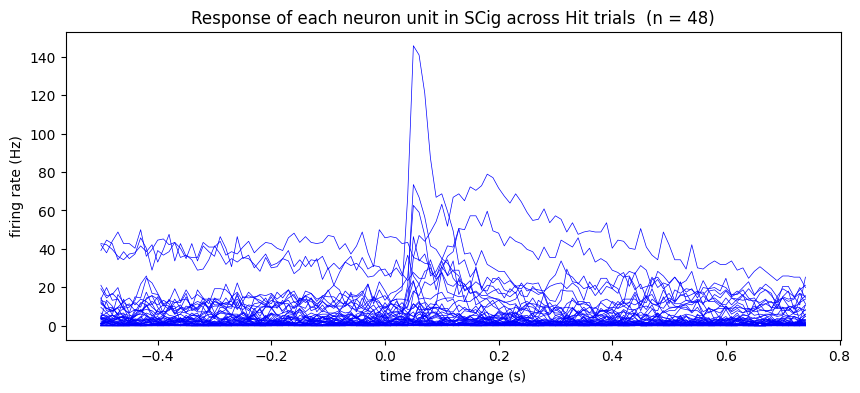

In [13]:
# Plot the single neuron response for all hit trials
# fig, ax = plt.subplots(figsize=(10, 4))


# Select hit trials
hit_trial_responses = trial_area_response_array[:, :, hit_array_indices]

# Calculate average spike count for each neuron across hit trials
all_unit_mean_hit_trials = np.mean(hit_trial_responses, axis=2)

# Plot each single neuronal response for average hit trials
num_neurons = trial_area_response_array.shape[0]


for i in range(num_neurons):
    plt.plot(time, all_unit_mean_hit_trials[i, :], label=f'Neuron {i+1}', color='blue', linewidth=0.5)


# ax.set_xlabel('time from change (s)')
# ax.set_ylabel('firing rate (Hz)')
# ax.set_title('Response of each neuron unit in {} across Hit trials  (n = {})'.format(area_of_interest, num_neurons))

In [14]:
print(time)

[-0.5  -0.49 -0.48 -0.47 -0.46 -0.45 -0.44 -0.43 -0.42 -0.41 -0.4  -0.39
 -0.38 -0.37 -0.36 -0.35 -0.34 -0.33 -0.32 -0.31 -0.3  -0.29 -0.28 -0.27
 -0.26 -0.25 -0.24 -0.23 -0.22 -0.21 -0.2  -0.19 -0.18 -0.17 -0.16 -0.15
 -0.14 -0.13 -0.12 -0.11 -0.1  -0.09 -0.08 -0.07 -0.06 -0.05 -0.04 -0.03
 -0.02 -0.01  0.    0.01  0.02  0.03  0.04  0.05  0.06  0.07  0.08  0.09
  0.1   0.11  0.12  0.13  0.14  0.15  0.16  0.17  0.18  0.19  0.2   0.21
  0.22  0.23  0.24  0.25  0.26  0.27  0.28  0.29  0.3   0.31  0.32  0.33
  0.34  0.35  0.36  0.37  0.38  0.39  0.4   0.41  0.42  0.43  0.44  0.45
  0.46  0.47  0.48  0.49  0.5   0.51  0.52  0.53  0.54  0.55  0.56  0.57
  0.58  0.59  0.6   0.61  0.62  0.63  0.64  0.65  0.66  0.67  0.68  0.69
  0.7   0.71  0.72  0.73  0.74]


In [15]:
# Plot the single neuron response for all miss trials
# fig, ax = plt.subplots(figsize=(10, 4))


# Select miss trials
miss_trial_responses = trial_area_response_array[:, :, miss_array_indices]

# Calculate average spike count for each neuron across miss trials
all_unit_mean_miss_trials = np.mean(miss_trial_responses, axis=2)

# Plot each single neuronal response for average hit trials
num_neurons = trial_area_response_array.shape[0]

# for i in range(num_neurons):
#     plt.plot(time, all_unit_mean_miss_trials[i, :], label=f'Neuron {i+1}', color='green', linewidth=0.5)


# ax.set_xlabel('time from change (s)')
# ax.set_ylabel('firing rate (Hz)')
# ax.set_title('Response of each neuron unit in {} across Miss trials  (n = {})'.format(area_of_interest, trial_area_response_array.shape[0]))

In [17]:
# Plot an example single neuron response for hit/miss trials
unit_num = trial_area_response_array.shape[0]

for i in range(unit_num):
    # fig, ax = plt.subplots(figsize=(10, 4))

    # Select 1 neuron for hit and miss trials
    single_unit_hit_trial = all_unit_mean_hit_trials[i,:]
    single_unit_miss_trial = all_unit_mean_miss_trials[i,:]

    # plt.plot(time, single_unit_hit_trial, label=f'Hit', color='blue', linewidth=1)
    # plt.plot(time, single_unit_miss_trial, label=f'Miss', color='green', linewidth=1)

    # ax.legend(['Hit', 'Miss']) 
    # ax.set_xlabel('time from change (s)')
    # ax.set_ylabel('firing rate (Hz)')
    # ax.set_title(f'Response of single neuron unit during hit and miss trials (#{i})')

    # plt.show()

In [18]:
# Normalise the hit and miss trials
# Calculate the max spike count for each all_unit_mean_miss_trials array
all_unit_mean_hit_trials = all_unit_mean_hit_trials[~np.all(all_unit_mean_hit_trials == 0, axis=1)]
max_spike_counts = np.max(all_unit_mean_hit_trials, axis=1)

# Normalize each all_unit_mean_miss_trials array by its max spike count
normalized_hit_responses = all_unit_mean_hit_trials / max_spike_counts[:, np.newaxis]

normalized_mean_hit = np.mean(normalized_hit_responses, axis=0)

# # Plot the normalized data
# # bins = np.arange(0, normalized_responses.shape[1])
# # Create a figure and axes
# fig, ax = plt.subplots(figsize=(10, 4))
# for i, response in enumerate(normalized_hit_responses):
#     ax.plot(time, response, color='blue',linewidth=0.2)

# ax.plot(time, normalized_mean_hit, color='blue',linewidth=1)

# # Set the plot title and labels
# ax.set_title('Normalised mean response of each neuron in {} acorss Hit trials (n = {})'.format(area_of_interest, trial_area_response_array.shape[0]))
# ax.set_xlabel('Time from change (s)')
# ax.set_ylabel('Normalized Firing Rate')

# # Show the plot
# plt.show()

In [19]:
# Normalise the hit and miss trials
# Calculate the max spike count for each all_unit_mean_miss_trials array
all_unit_mean_miss_trials = all_unit_mean_miss_trials[~np.all(all_unit_mean_miss_trials == 0, axis=1)]
max_spike_counts = np.max(all_unit_mean_miss_trials, axis=1)

# Normalize each all_unit_mean_miss_trials array by its max spike count
normalized_miss_responses = all_unit_mean_miss_trials / max_spike_counts[:, np.newaxis]

normalized_mean_miss = np.mean(normalized_miss_responses, axis=0)

# Plot the normalized data
# bins = np.arange(0, normalized_responses.shape[1])
# Create a figure and axes
# fig, ax = plt.subplots(figsize=(10, 4))
# for i, response in enumerate(normalized_miss_responses):
#     ax.plot(time, response, color='green',linewidth=0.2)

# ax.plot(time, normalized_mean_miss, color='green',linewidth=1)

# # Set the plot title and labels
# ax.set_title('Normalised mean response of each neuron in {} acorss miss trials (n = {})'.format(area_of_interest, trial_area_response_array.shape[0]))
# ax.set_xlabel('Time from change (s)')
# ax.set_ylabel('Normalized Firing Rate')

# # Show the plot
# plt.show()

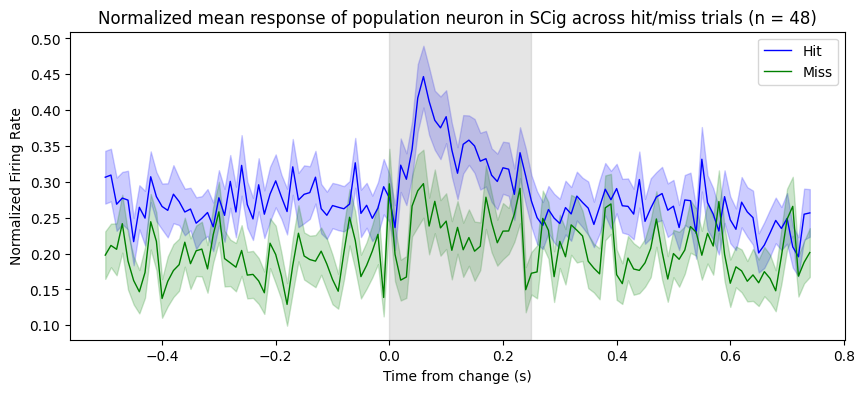

In [20]:
# Calculate standard error of the mean (SEM) for hit and miss responses
sem_hit = np.std(normalized_hit_responses, axis=0) / np.sqrt(normalized_hit_responses.shape[0])
sem_miss = np.std(normalized_miss_responses, axis=0) / np.sqrt(normalized_miss_responses.shape[0])

# Create a figure and axes
fig, ax = plt.subplots(figsize=(10, 4))

# Plot the normalized mean responses with error bars representing SEM
ax.plot(time, normalized_mean_hit, color='blue', linewidth=1, label='Hit')
ax.fill_between(time, normalized_mean_hit - sem_hit, normalized_mean_hit + sem_hit, alpha=0.2, color='blue')

ax.plot(time, normalized_mean_miss, color='green', linewidth=1, label='Miss')
ax.fill_between(time, normalized_mean_miss - sem_miss, normalized_mean_miss + sem_miss, alpha=0.2, color='green')

ax.axvspan(0, 0.25, alpha=0.2, color='gray')

# Set the plot title and labels
ax.legend()
ax.set_title('Normalized mean response of population neuron in {} across hit/miss trials (n = {})'.format(area_of_interest, trial_area_response_array.shape[0]))
ax.set_xlabel('Time from change (s)')
ax.set_ylabel('Normalized Firing Rate')

# Show the plot
plt.show()

In [22]:
print(time)
print(len(time))
print(len(normalized_mean_hit))
print(f'normalized_mean_hit is {normalized_mean_hit}')


[-0.5  -0.49 -0.48 -0.47 -0.46 -0.45 -0.44 -0.43 -0.42 -0.41 -0.4  -0.39
 -0.38 -0.37 -0.36 -0.35 -0.34 -0.33 -0.32 -0.31 -0.3  -0.29 -0.28 -0.27
 -0.26 -0.25 -0.24 -0.23 -0.22 -0.21 -0.2  -0.19 -0.18 -0.17 -0.16 -0.15
 -0.14 -0.13 -0.12 -0.11 -0.1  -0.09 -0.08 -0.07 -0.06 -0.05 -0.04 -0.03
 -0.02 -0.01  0.    0.01  0.02  0.03  0.04  0.05  0.06  0.07  0.08  0.09
  0.1   0.11  0.12  0.13  0.14  0.15  0.16  0.17  0.18  0.19  0.2   0.21
  0.22  0.23  0.24  0.25  0.26  0.27  0.28  0.29  0.3   0.31  0.32  0.33
  0.34  0.35  0.36  0.37  0.38  0.39  0.4   0.41  0.42  0.43  0.44  0.45
  0.46  0.47  0.48  0.49  0.5   0.51  0.52  0.53  0.54  0.55  0.56  0.57
  0.58  0.59  0.6   0.61  0.62  0.63  0.64  0.65  0.66  0.67  0.68  0.69
  0.7   0.71  0.72  0.73  0.74]
125
125
normalized_mean_hit is [0.30647013 0.30944963 0.26880365 0.27738993 0.27455125 0.2165904
 0.26451215 0.24942049 0.30709778 0.2793726  0.2656666  0.26024907
 0.28280158 0.27253592 0.25795906 0.2620852  0.2423877  0.24911499
 0.2572

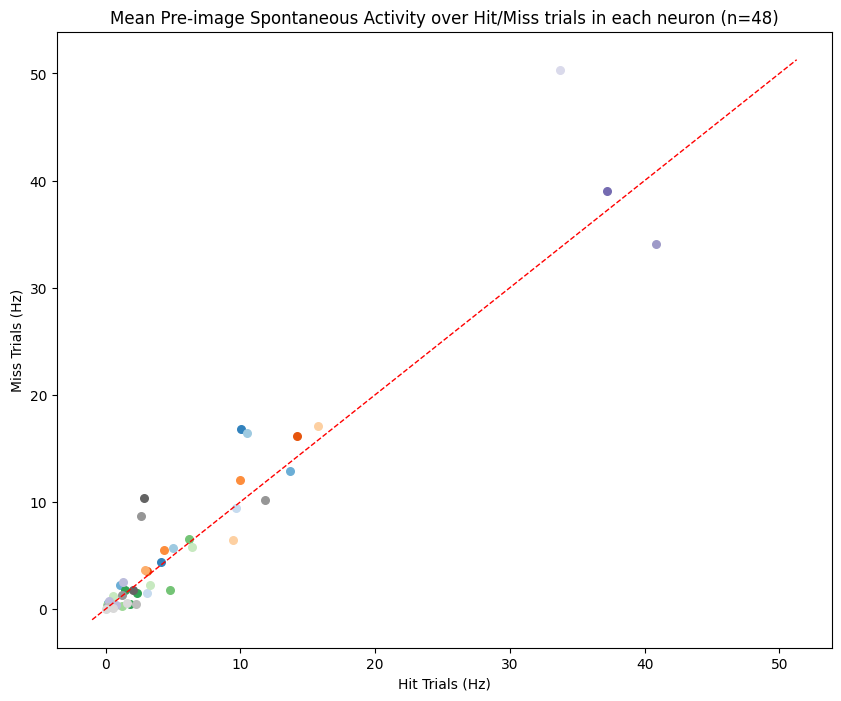

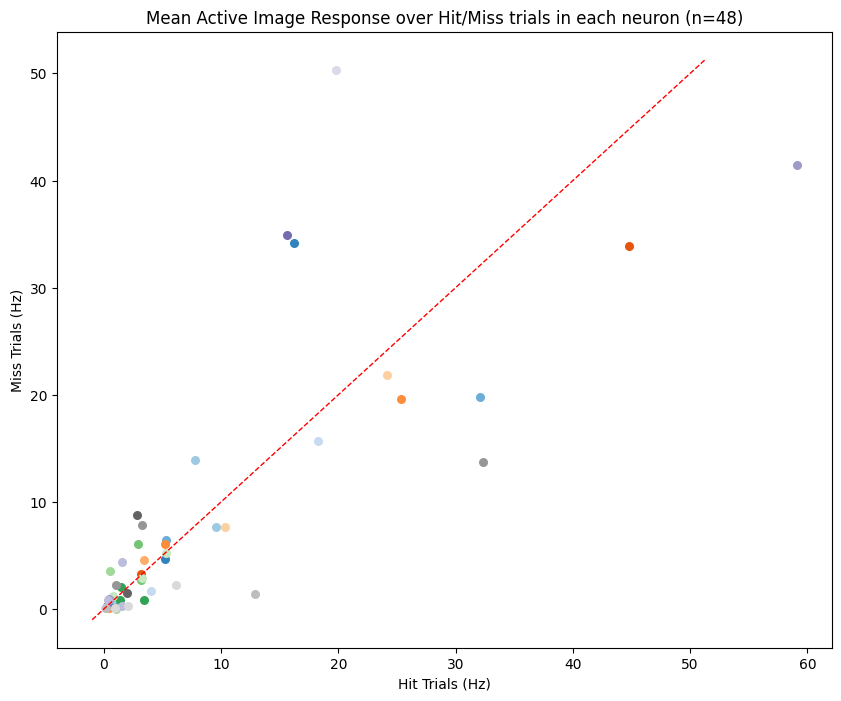

In [23]:
# Define the time range
pre_spon_start_time = -0.5
image_start_time = 0.0
image_end_time = 0.25
post_spon_end_time = 0.75

# Create a boolean mask for the time range
pre_spon_mask = (time >= pre_spon_start_time) & (time < image_start_time)
image_mask = (time >= image_start_time) & (time <= image_end_time)

# store each unit mean reponse during pre-image spontaneous response
pre_spon_single_unit_hit_spike_time = []
pre_spon_single_unit_miss_spike_time = []

# store each unit mean reponse during image response
image_single_unit_hit_spike_time = []
image_single_unit_miss_spike_time = []

for i in range(unit_num):

    # Select 1 neuron for hit and miss trials
    single_unit_hit_trial = all_unit_mean_hit_trials[i,:]
    single_unit_miss_trial = all_unit_mean_miss_trials[i,:]

    # Use the mask to extract firing rates for the preimage spontaneous response
    # in each neuron and find the mean in hit and miss
    pre_spon_hit_response = single_unit_hit_trial[pre_spon_mask]
    mean_pre_spon_hit_response = pre_spon_hit_response.mean()
    pre_spon_single_unit_hit_spike_time.append(mean_pre_spon_hit_response)

    pre_spon_miss_response = single_unit_miss_trial[pre_spon_mask]
    mean_pre_spon_miss_response = pre_spon_miss_response.mean()
    pre_spon_single_unit_miss_spike_time.append(mean_pre_spon_miss_response)


    # Use the mask to extract firing rates for the image response
    # in each neuron and find the mean in hit and miss
    image_hit_response = single_unit_hit_trial[image_mask]
    mean_image_hit_response = image_hit_response.mean()
    image_single_unit_hit_spike_time.append(mean_image_hit_response)

    image_miss_response = single_unit_miss_trial[image_mask]
    mean_image_miss_response = image_miss_response.mean()
    image_single_unit_miss_spike_time.append(mean_image_miss_response)


# Create an array of colors for each neuron
colors = plt.cm.tab20c(np.linspace(0, 1, unit_num))

# Scatter plot for pre-image spontaneous activity
fig, ax = plt.subplots(figsize=(10, 8))
for i in range(unit_num):
    plt.scatter(pre_spon_single_unit_hit_spike_time[i], 
                pre_spon_single_unit_miss_spike_time[i], 
                color=colors[i], label=f'Neuron {i + 1}', s=30)

# Generate x values
x_values = np.linspace(-1, max(pre_spon_single_unit_miss_spike_time) + 1, 100)
y_values = x_values

# Plot the diagonal line
plt.plot(x_values, y_values, color='red', linestyle='--', linewidth=1)

plt.xlabel('Hit Trials (Hz)')
plt.ylabel('Miss Trials (Hz)')
plt.title(f'Mean Pre-image Spontaneous Activity over Hit/Miss trials in each neuron (n={unit_num})')
# plt.legend(fontsize='small')
plt.show()

# Scatter plot for image response
fig, ax = plt.subplots(figsize=(10, 8))
for i in range(unit_num):
    plt.scatter(image_single_unit_hit_spike_time[i], 
                image_single_unit_miss_spike_time[i], 
                color=colors[i], label=f'Neuron {i + 1}',s=30)

# Generate x values
x_values = np.linspace(-1, max(image_single_unit_miss_spike_time) + 1, 100)
y_values = x_values

# Plot the diagonal line
plt.plot(x_values, y_values, color='red', linestyle='--', linewidth=1)

plt.xlabel('Hit Trials (Hz)')
plt.ylabel('Miss Trials (Hz)')
plt.title(f'Mean Active Image Response over Hit/Miss trials in each neuron (n={unit_num})')
# plt.legend(fontsize='small')
plt.show()

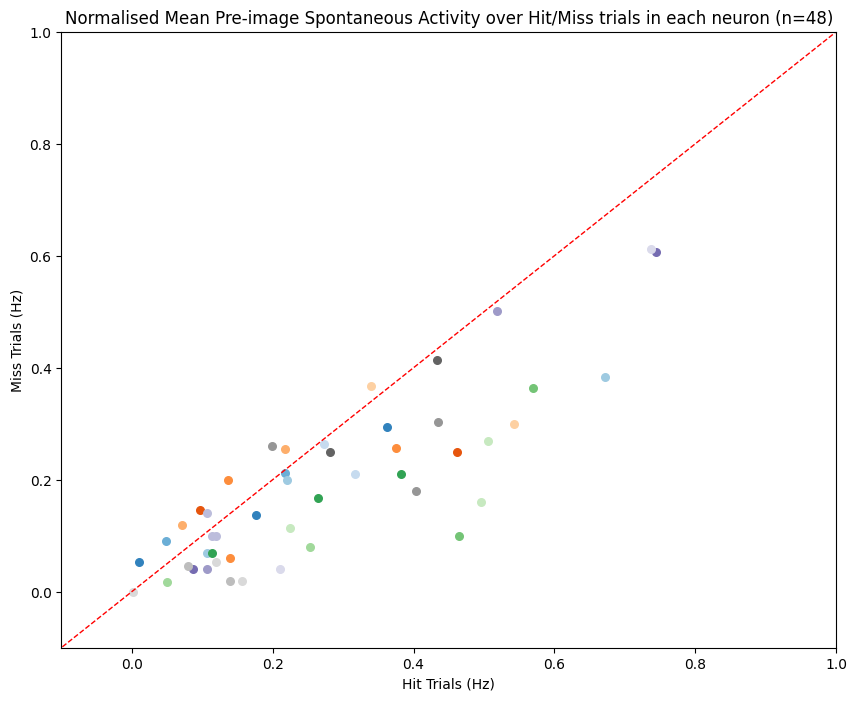

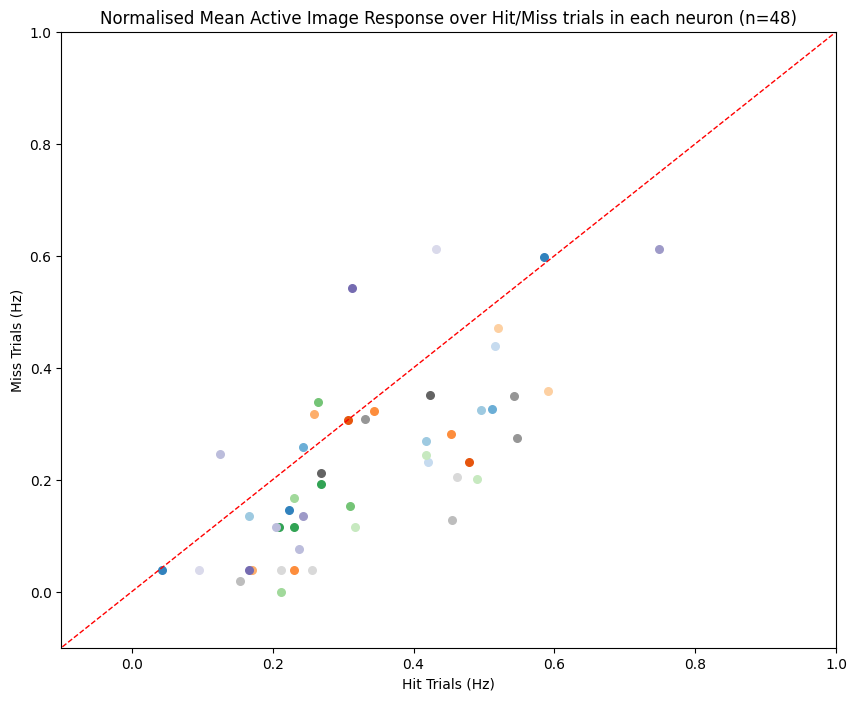

In [24]:
# Define the time range
pre_spon_start_time = -0.5
image_start_time = 0.0
image_end_time = 0.25
post_spon_end_time = 0.75

# Create a boolean mask for the time range
pre_spon_mask = (time >= pre_spon_start_time) & (time < image_start_time)
image_mask = (time >= image_start_time) & (time <= image_end_time)

# store each unit mean reponse during pre-image spontaneous response
pre_spon_single_unit_hit_spike_time = []
pre_spon_single_unit_miss_spike_time = []

# store each unit mean reponse during image response
image_single_unit_hit_spike_time = []
image_single_unit_miss_spike_time = []

for i in range(unit_num):

    # Select 1 neuron for hit and miss trials
    single_unit_hit_trial = normalized_hit_responses[i,:]
    single_unit_miss_trial = normalized_miss_responses[i,:]

    # Use the mask to extract firing rates for the preimage spontaneous response
    # in each neuron and find the mean in hit and miss
    pre_spon_hit_response = single_unit_hit_trial[pre_spon_mask]
    mean_pre_spon_hit_response = pre_spon_hit_response.mean()
    pre_spon_single_unit_hit_spike_time.append(mean_pre_spon_hit_response)

    pre_spon_miss_response = single_unit_miss_trial[pre_spon_mask]
    mean_pre_spon_miss_response = pre_spon_miss_response.mean()
    pre_spon_single_unit_miss_spike_time.append(mean_pre_spon_miss_response)


    # Use the mask to extract firing rates for the image response
    # in each neuron and find the mean in hit and miss
    image_hit_response = single_unit_hit_trial[image_mask]
    mean_image_hit_response = image_hit_response.mean()
    image_single_unit_hit_spike_time.append(mean_image_hit_response)

    image_miss_response = single_unit_miss_trial[image_mask]
    mean_image_miss_response = image_miss_response.mean()
    image_single_unit_miss_spike_time.append(mean_image_miss_response)


# Create an array of colors for each neuron
colors = plt.cm.tab20c(np.linspace(0, 1, unit_num))

# Scatter plot for pre-image spontaneous activity
fig, ax = plt.subplots(figsize=(10, 8))
for i in range(unit_num):
    plt.scatter(pre_spon_single_unit_hit_spike_time[i], 
                pre_spon_single_unit_miss_spike_time[i], 
                color=colors[i], label=f'Neuron {i + 1}', s=30)

# Generate x values
x_values = np.linspace(-1, max(pre_spon_single_unit_miss_spike_time) + 1, 100)
y_values = x_values

# Plot the diagonal line
plt.plot(x_values, y_values, color='red', linestyle='--', linewidth=1)

plt.xlim(-0.1, 1)  
plt.ylim(-0.1, 1) 

plt.xlabel('Hit Trials (Hz)')
plt.ylabel('Miss Trials (Hz)')
plt.title(f'Normalised Mean Pre-image Spontaneous Activity over Hit/Miss trials in each neuron (n={unit_num})')
# plt.legend(fontsize='small')
plt.show()

# Scatter plot for image response
fig, ax = plt.subplots(figsize=(10, 8))
for i in range(unit_num):
    plt.scatter(image_single_unit_hit_spike_time[i], 
                image_single_unit_miss_spike_time[i], 
                color=colors[i], label=f'Neuron {i + 1}',s=30)

# Generate x values
x_values = np.linspace(-1, max(image_single_unit_miss_spike_time) + 1, 100)
y_values = x_values

# Plot the diagonal line
plt.plot(x_values, y_values, color='red', linestyle='--', linewidth=1)

plt.xlim(-0.1, 1)  
plt.ylim(-0.1, 1) 

plt.xlabel('Hit Trials (Hz)')
plt.ylabel('Miss Trials (Hz)')
plt.title(f'Normalised Mean Active Image Response over Hit/Miss trials in each neuron (n={unit_num})')
# plt.legend(fontsize='small')
plt.show()

In [25]:
from scipy.stats import ttest_ind

# Perform independent samples t-test
t_stat, p_value = ttest_ind(normalized_mean_hit, normalized_mean_miss)

# Display the results
print(f'T-statistic: {t_stat}')
print(f'P-value: {p_value}')

# Check for statistical significance
alpha = 0.05
if p_value < alpha:
    print('The difference between hit and miss mean population response is statistically significant.')
else:
    print('There is no significant difference between hit and miss mean population response.')

T-statistic: 15.095580291593784
P-value: 5.821279583094663e-37
The difference between hit and miss mean population response is statistically significant.


Text(0.5, 1.0, 'Mean response in SCig during Miss and Hit trials (n = 48)')

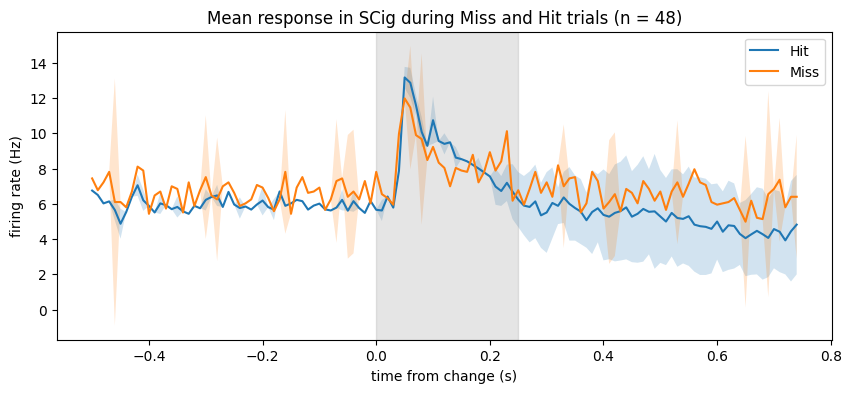

In [26]:
fig, ax = plt.subplots(figsize=(10, 4))

# Loop through our familiar and novel array indices
for id in [hit_array_indices,miss_array_indices]:
    
    # Use these indices to select the corresponding data from our data array
    relevant_trials = trial_area_response_array[:, :, id]
    
    # Average over trials, then subtract the baseline before averaging over neurons
    mean_over_trials = (np.mean(relevant_trials, axis=(2)))

    # Calculate the standard error of the mean (SEM) over neurons
    sem_over_neurons = np.std(relevant_trials, axis=(2)) / np.sqrt(relevant_trials.shape[2])
    
    # Average over units 
    mean_over_neurons_trials = np.mean(mean_over_trials, axis=(0))
    
    
    ax.plot(time, mean_over_neurons_trials)

    # Plot the mean response with error bars representing SEM
    ax.fill_between(time, mean_over_neurons_trials - sem_over_neurons[0], mean_over_neurons_trials + sem_over_neurons[0], alpha=0.2)
    
ax.axvspan(0, 0.25, alpha=0.2, color='gray')

ax.set_xlabel('time from change (s)')
ax.set_ylabel('firing rate (Hz)')

ax.legend(['Hit', 'Miss'])
ax.set_title('Mean response in {} during Miss and Hit trials (n = {})'.format(area_of_interest, trial_area_response_array.shape[0]))


Text(0.5, 1.0, 'Mean stimulus-evoked changes in SCig during Miss and Hit trials (n = 48)')

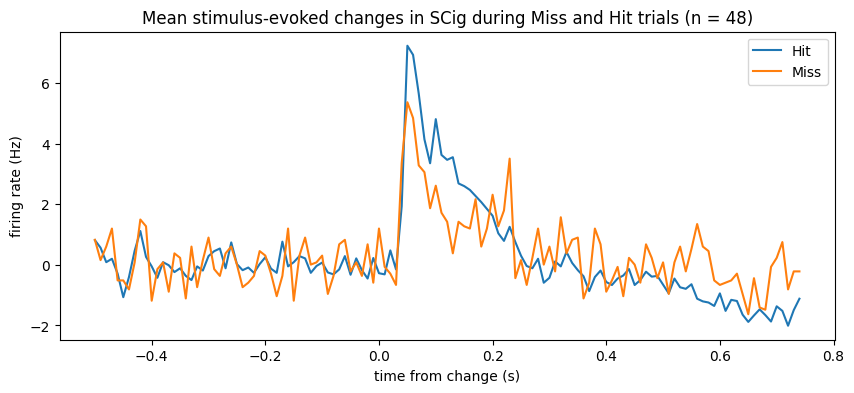

In [33]:
# For stimulus-evoked changes in firing rate, we need to correct for the baseline.
# before averaging over neurons, first subtract each neuron's baseline firing rate (0.2 - 0 sec before the change).

fig, ax = plt.subplots(figsize=(10, 4))

# Loop through our familiar and novel array indices
for id in [hit_array_indices,miss_array_indices]:
    
    # Use these indices to select the corresponding data from our data array
    relevant_trials = trial_area_response_array[:, :, id]
    
    baseline_mean = np.mean(relevant_trials[:,(time>=-0.2)&(time<0), :], axis=(1,2))
    
    # Average over trials, then subtract the baseline before averaging over neurons
    mean_over_trials_minus_baseline = (np.mean(relevant_trials, axis=(2)).T-baseline_mean).T
    
    # Average over units 
    mean_over_neurons_trials = np.mean(mean_over_trials_minus_baseline, axis=(0))
    
    
    ax.plot(time, mean_over_neurons_trials)

ax.set_xlabel('time from change (s)')
ax.set_ylabel('firing rate (Hz)')

ax.legend(['Hit', 'Miss'])
ax.set_title('Mean stimulus-evoked changes in {} during Miss and Hit trials (n = {})'.format(area_of_interest, trial_area_response_array.shape[0]))


# Pupil size for Hit versus miss trials

In [34]:
# Grab pupil area data (eliminate blinks)
eye_tracking = session.eye_tracking
eye_tracking_noblinks = eye_tracking[~eye_tracking['likely_blink']]


Text(0.5, 0, 'Time from change (s)')

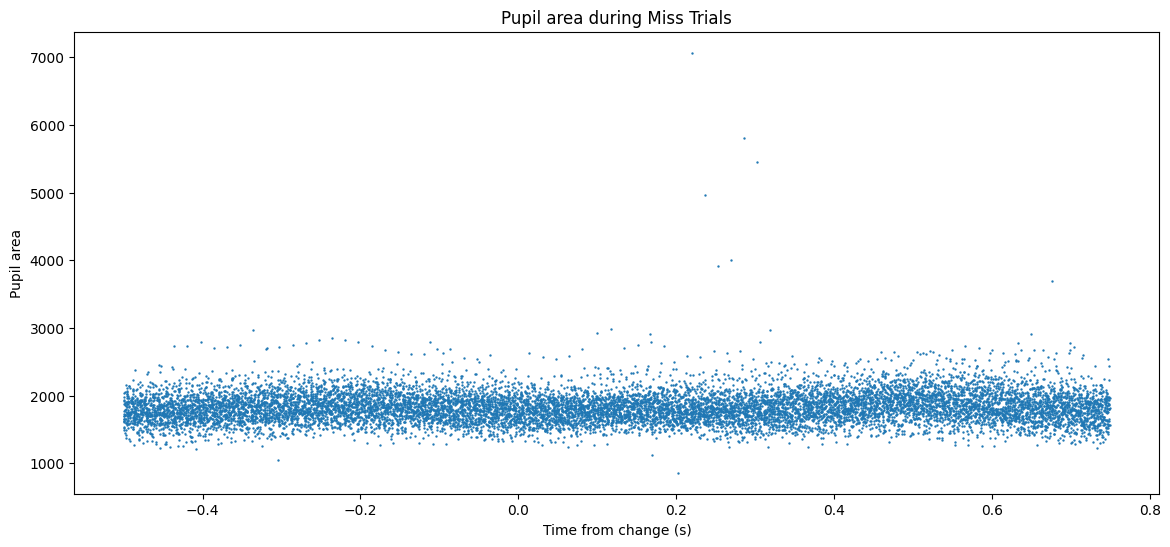

In [35]:


# Create a dataFrame that contains timestamps and pupil_area_raw
df = pd.DataFrame(eye_tracking_noblinks)
df_pupil_area_timestamps = df[['timestamps','pupil_area']]
df_pupil_area_timestamps


# Find the start and end times of each trial 
time_before_change = 0.5 #how much time to plot before the miss
duration = 1.25

start_times = hit_trials['change_time_with_display_delay'] - time_before_change  # (is_change image start time for hit)
# start_times = miss_trials['change_time_with_display_delay'] - time_before_change
end_times = start_times + duration


df_start_end = pd.DataFrame()
df_start_end['start_time'] = start_times
df_start_end['end_time'] = end_times

df_start_end = df_start_end.iloc[:]
df_start_end



# Find pupil size for each trials
filtered_rows = []

pupil_area_change = pd.DataFrame()

for index, row in df_start_end.iterrows():
    mask = (df_pupil_area_timestamps['timestamps'] >= row['start_time']) & (df_pupil_area_timestamps['timestamps'] <= row['end_time'])
    filtered_rows = df_pupil_area_timestamps.loc[mask].copy()
    filtered_rows['timestamp_diff'] = filtered_rows['timestamps'] - row['start_time']
    pupil_area_change = pd.concat([pupil_area_change, filtered_rows])
    

pupil_area_change['Time from Change'] = pupil_area_change['timestamp_diff'] - time_before_change
pupil_area_change


# Plot the pupil area during trials
x = pupil_area_change['Time from Change']
y = pupil_area_change['pupil_area']

fig, ax = plt.subplots()
fig.set_size_inches(14,6)


pupil_plt = ax.scatter(x, y,s=0.5)

ax.set_title('Pupil area during Miss Trials')
ax.set_ylabel('Pupil area')
ax.set_xlabel('Time from change (s)')

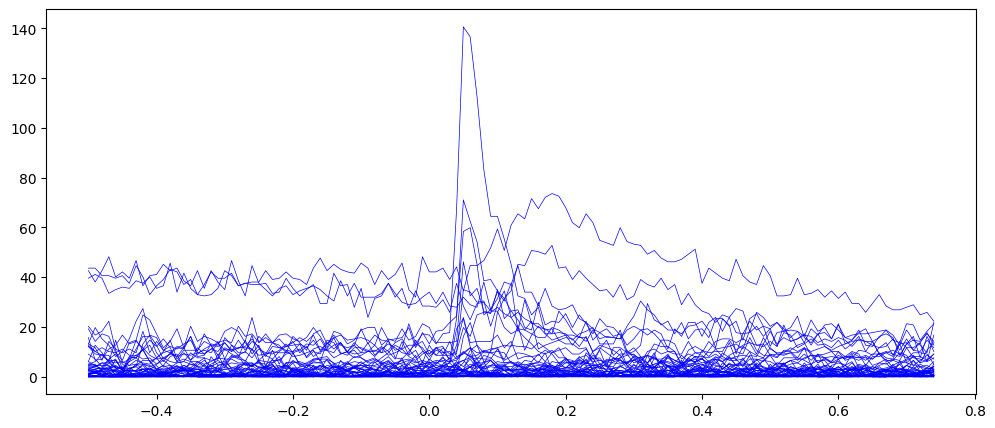

In [56]:
from scipy.stats import linregress
from scipy.interpolate import interp1d


# All neurons fr
average_response = np.mean(trial_area_response_array, axis=2)   # 125 firing rate
num_neurons = trial_area_response_array.shape[0]    # 48 neurons

fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot()

for i in range(num_neurons):
    plt.plot(time, average_response[i, :], label=f'Neuron {i+1}', color='blue', linewidth=0.5)


# All pupil area
start_time = trials['change_time_with_display_delay'] - time_before_change
end_times = start_times + duration

df_start_end = pd.DataFrame()
df_start_end['start_time'] = start_times
df_start_end['end_time'] = end_times
df_start_end = df_start_end.iloc[:]

# Find pupil size for each trials
filtered_rows = []

pupil_area_change = pd.DataFrame()

for index, row in df_start_end.iterrows():
    mask = (df_pupil_area_timestamps['timestamps'] >= row['start_time']) & (df_pupil_area_timestamps['timestamps'] <= row['end_time'])
    filtered_rows = df_pupil_area_timestamps.loc[mask].copy()
    filtered_rows['timestamp_diff'] = filtered_rows['timestamps'] - row['start_time']
    pupil_area_change = pd.concat([pupil_area_change, filtered_rows])
    

pupil_area_change['Time from Change'] = pupil_area_change['timestamp_diff'] - time_before_change

all_neuron_pupil_area = pupil_area_change['pupil_area'] # 12414 pupil area



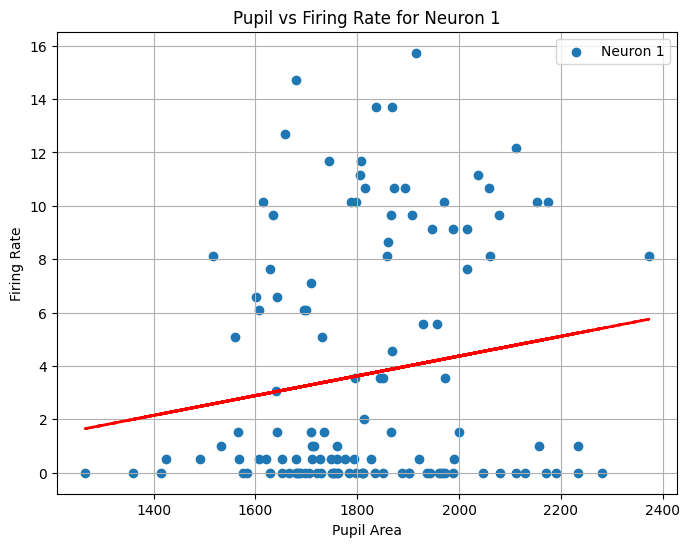

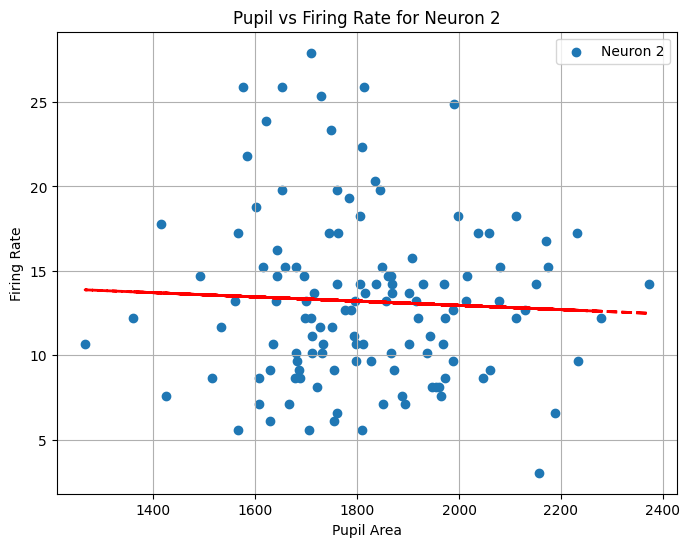

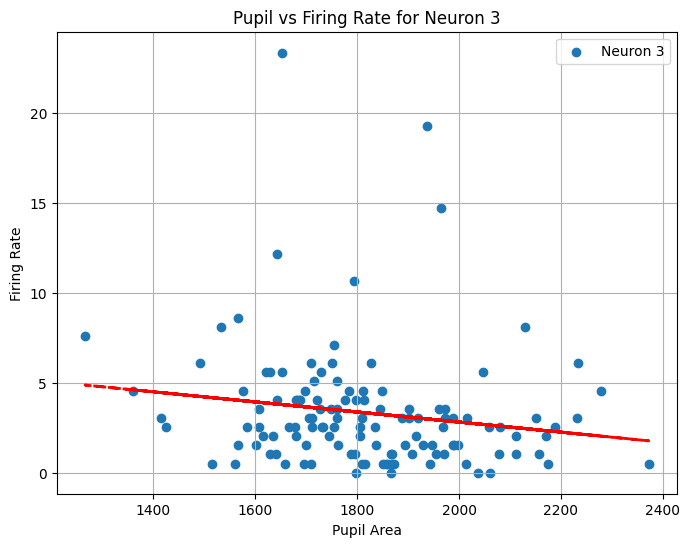

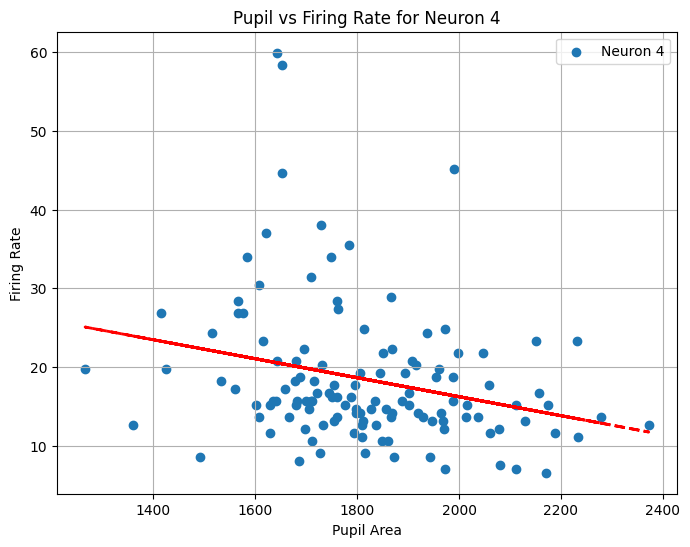

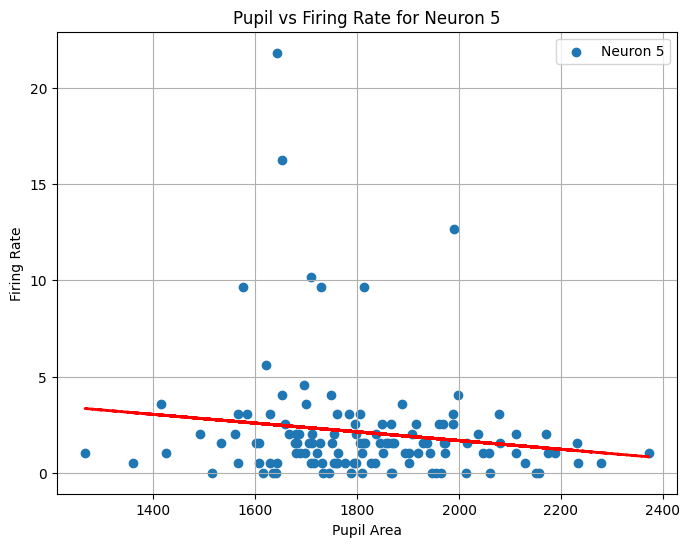

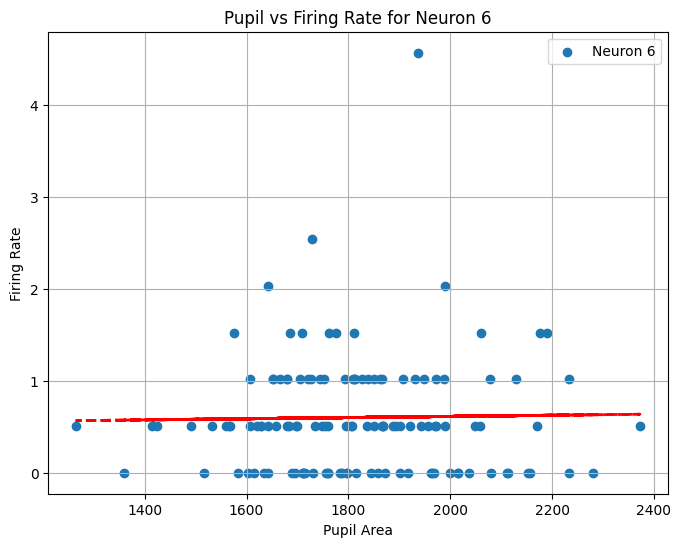

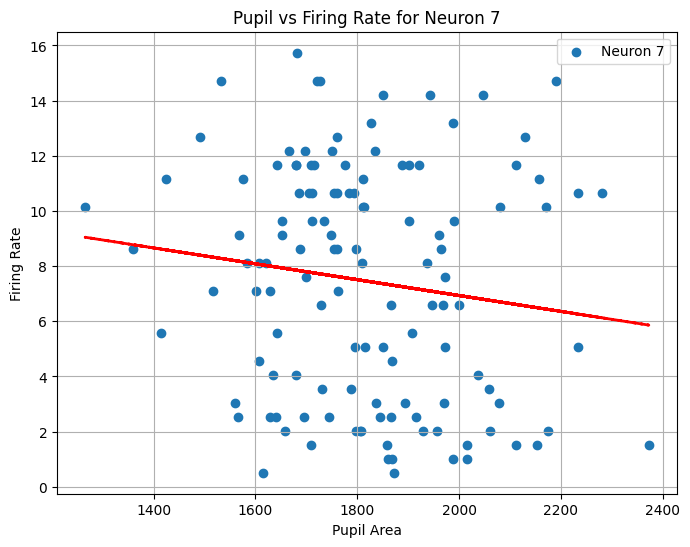

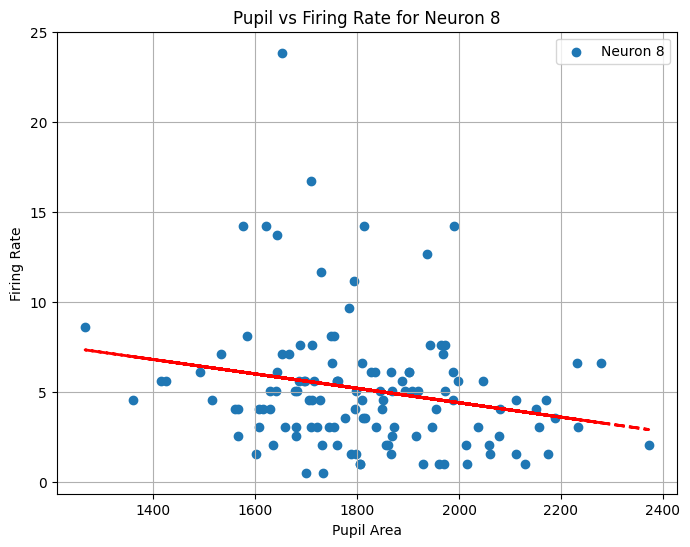

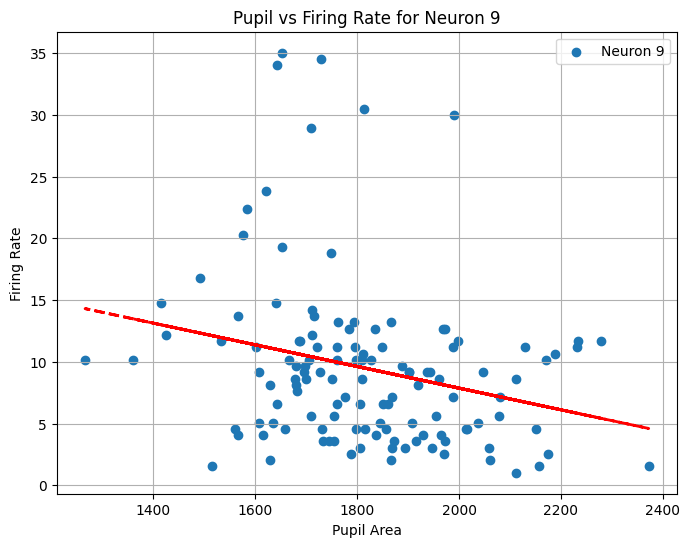

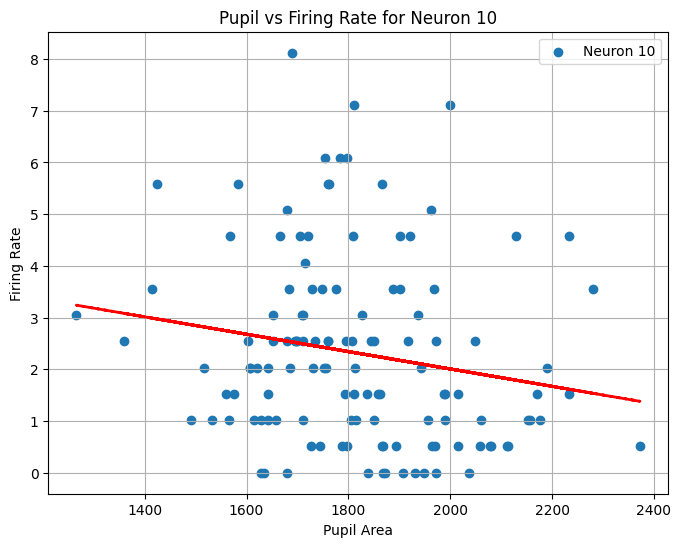

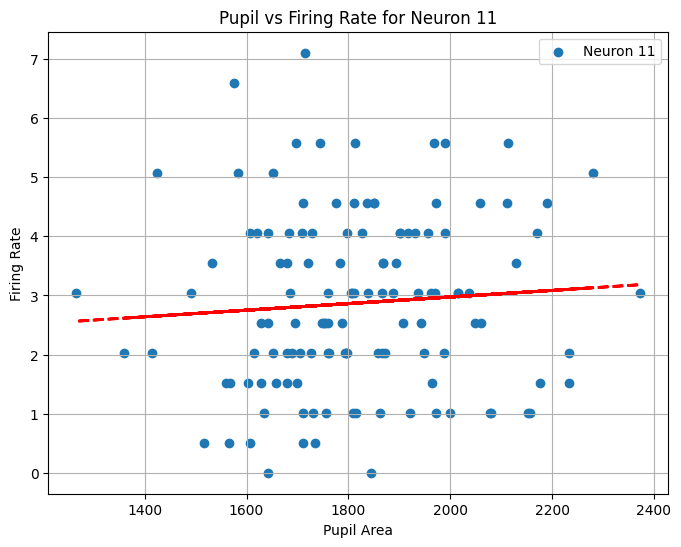

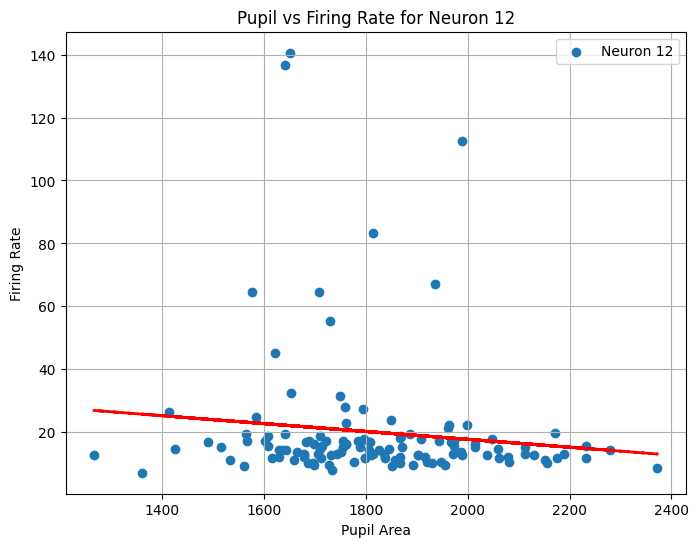

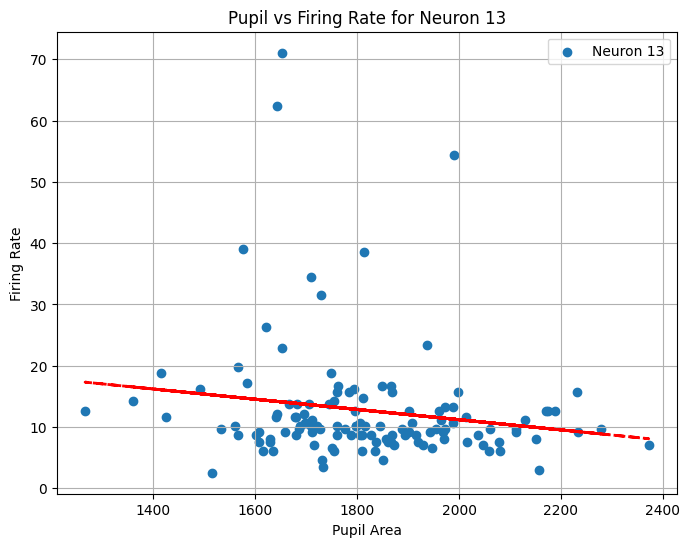

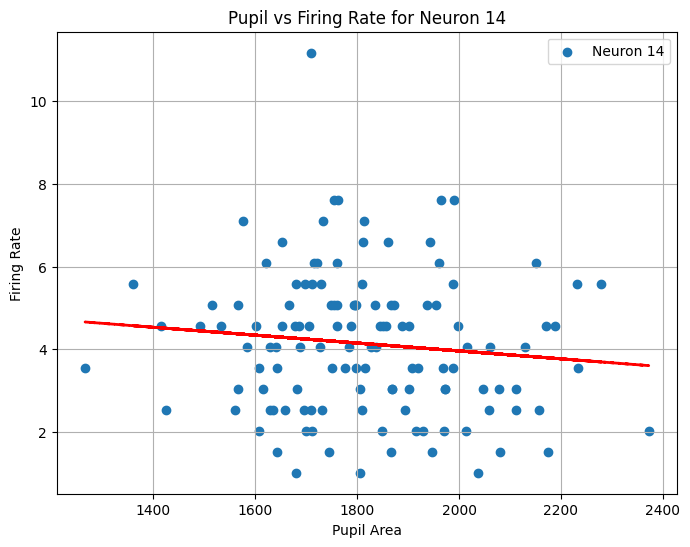

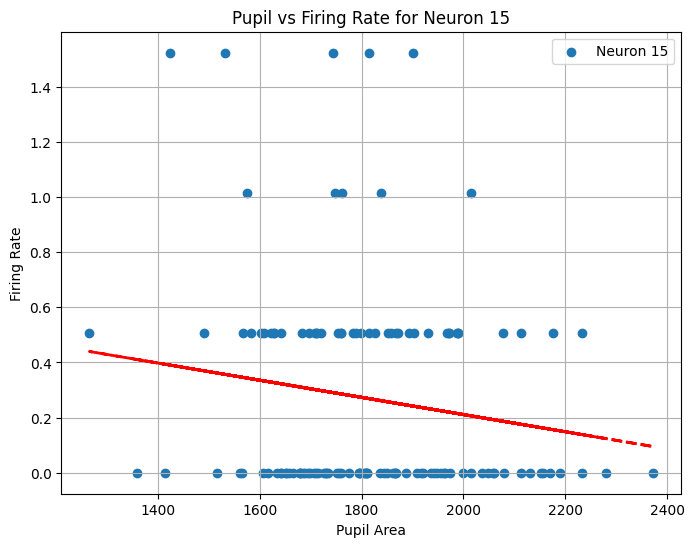

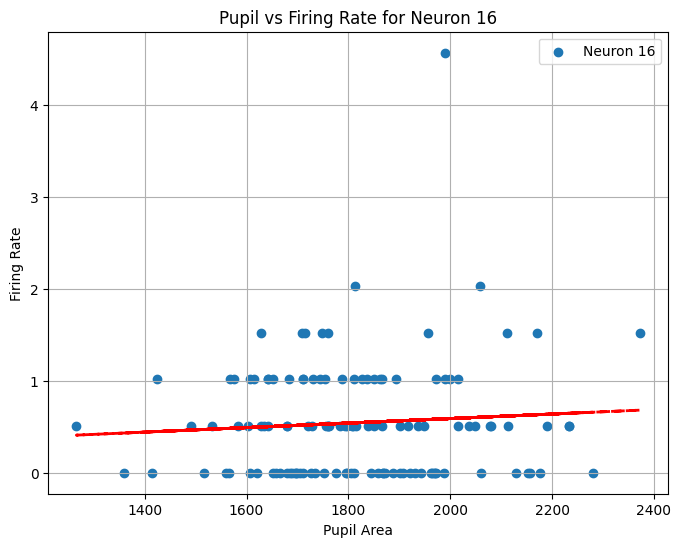

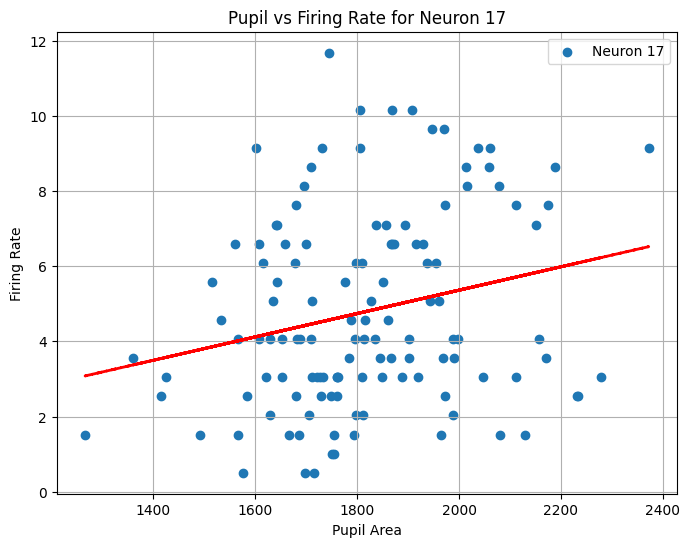

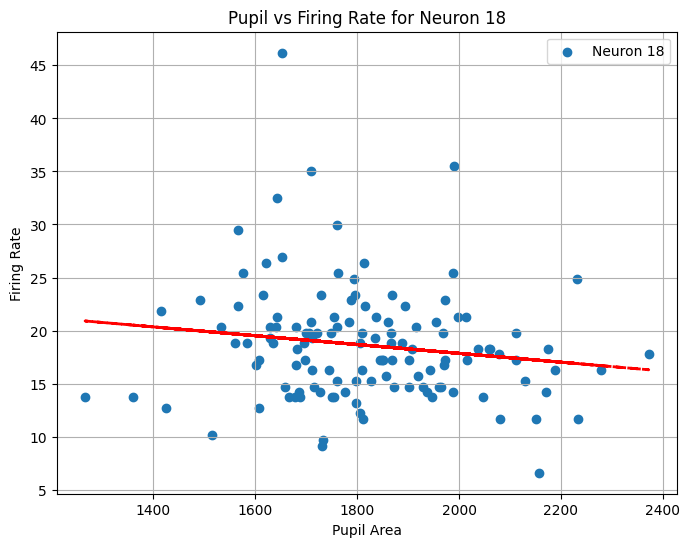

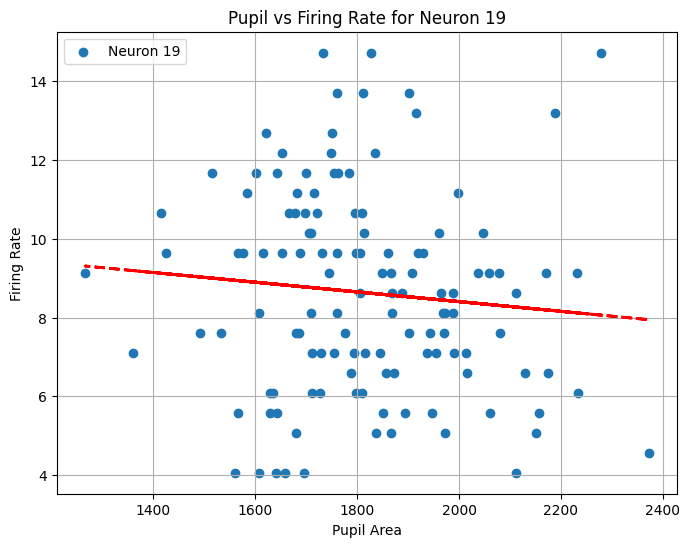

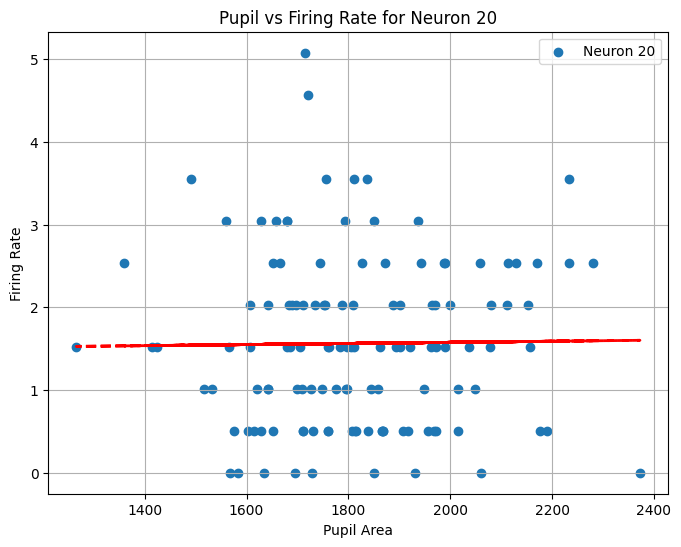

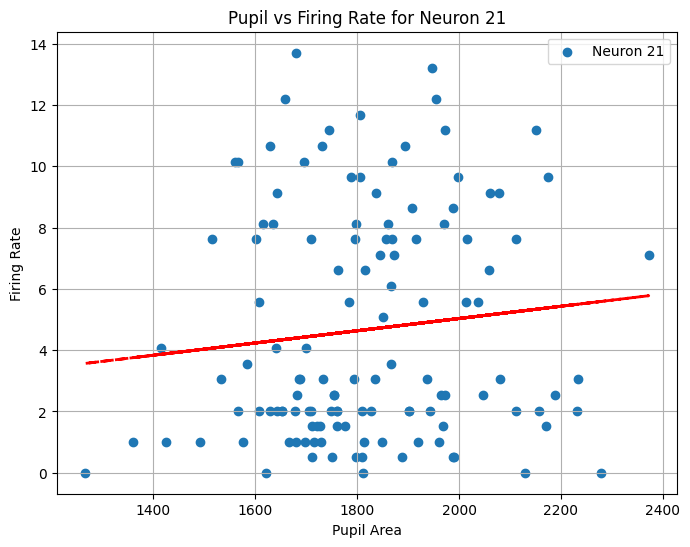

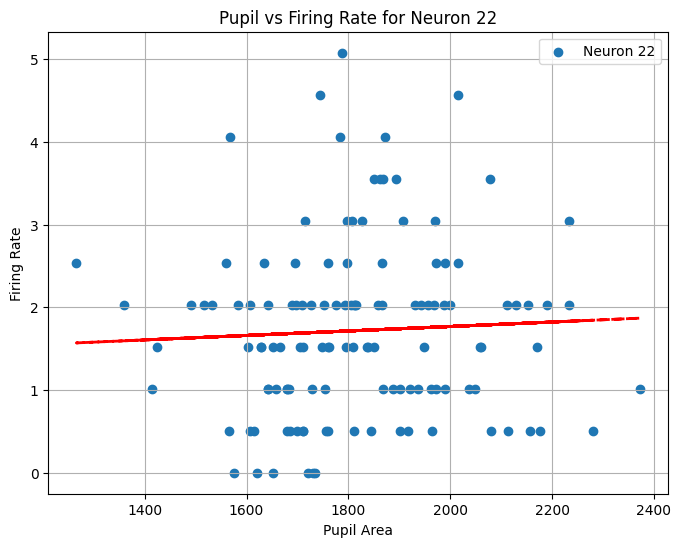

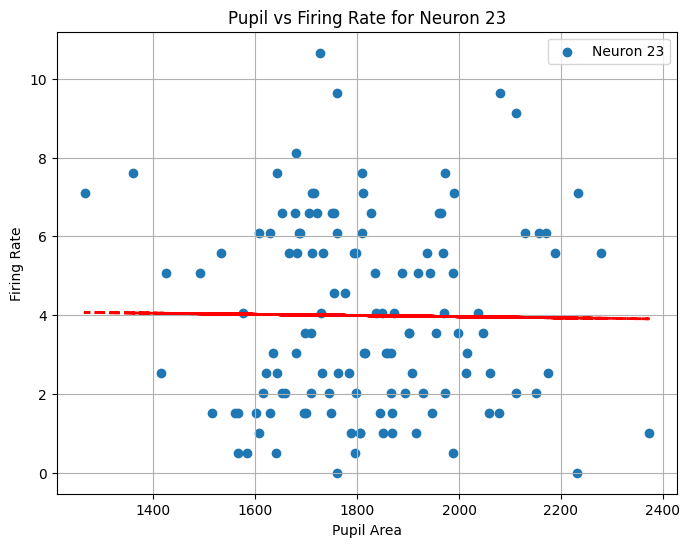

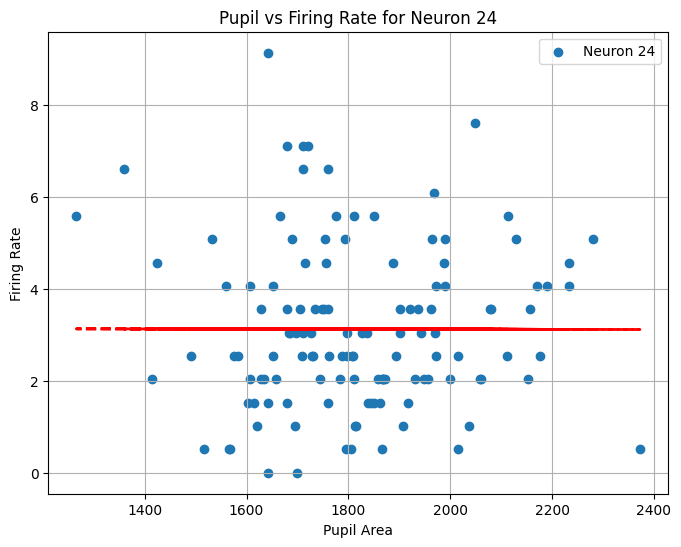

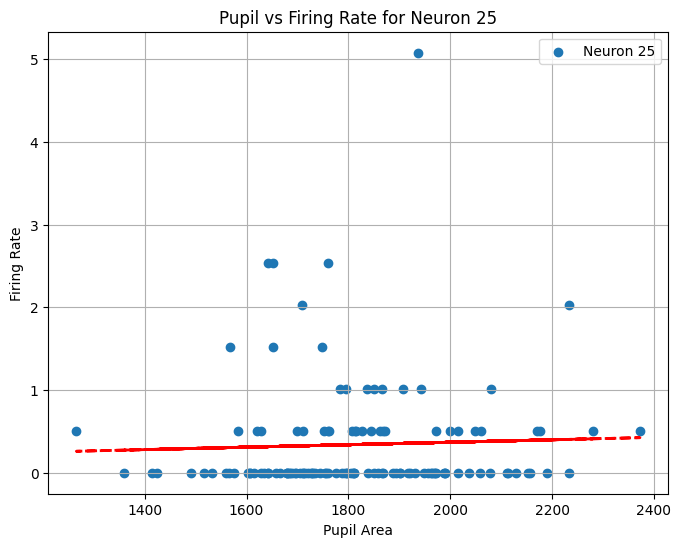

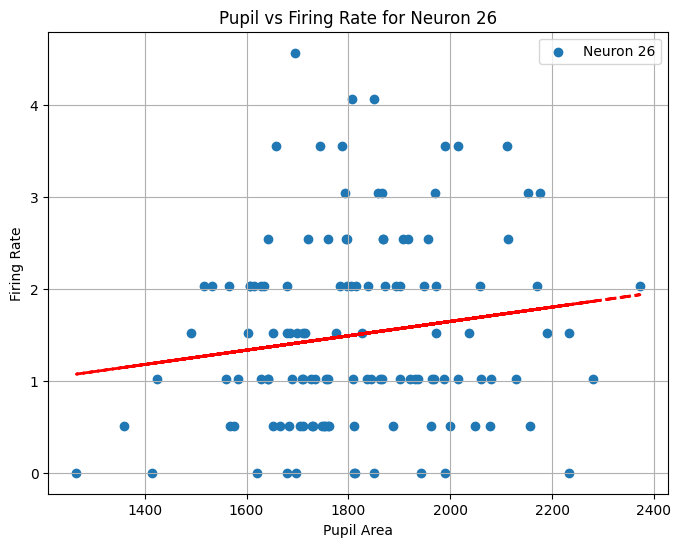

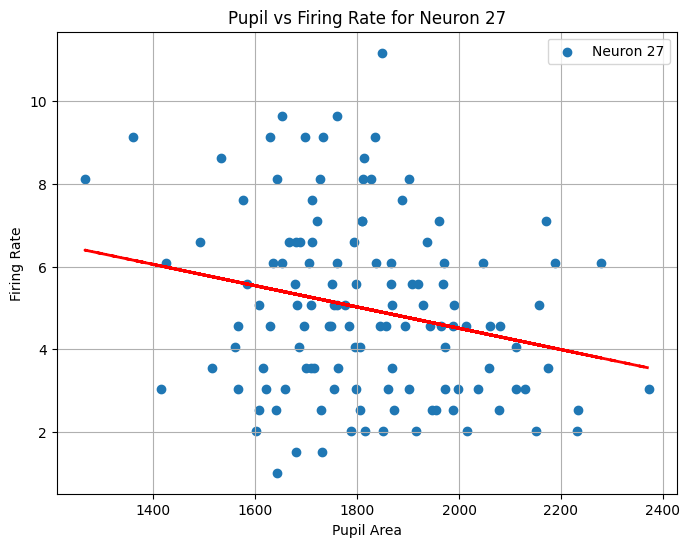

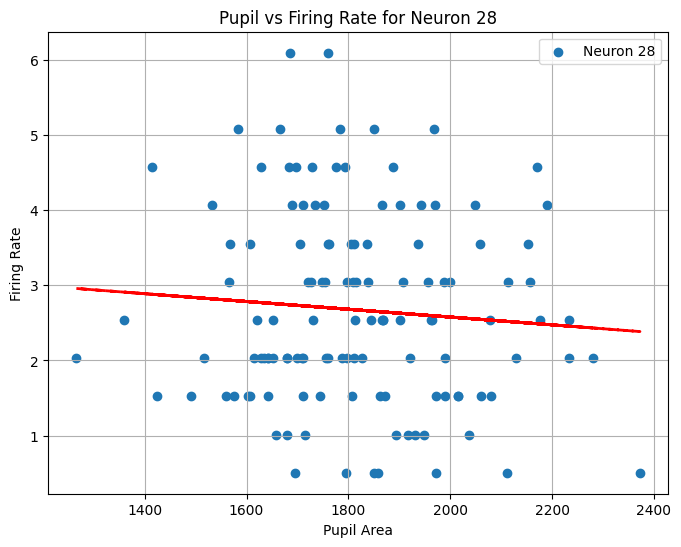

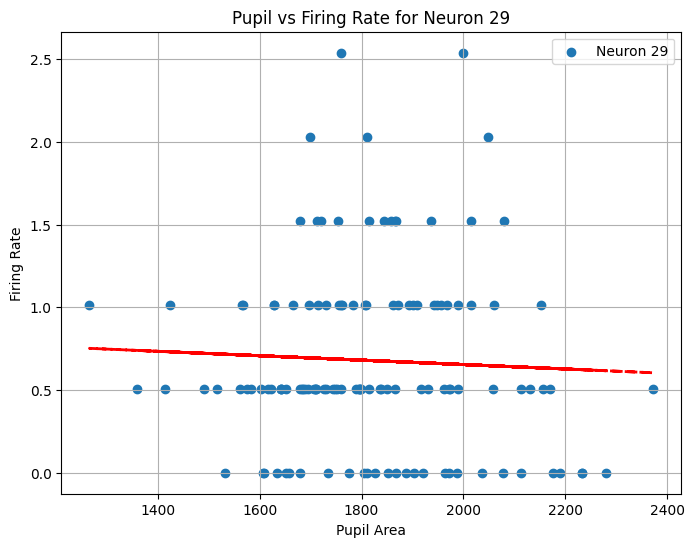

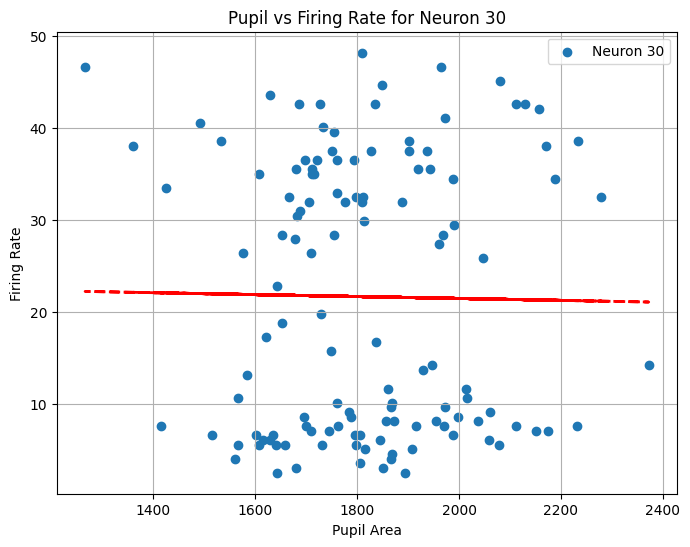

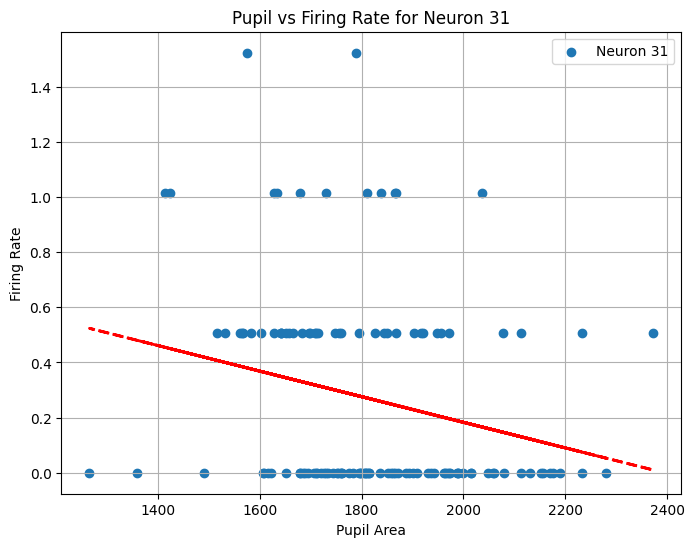

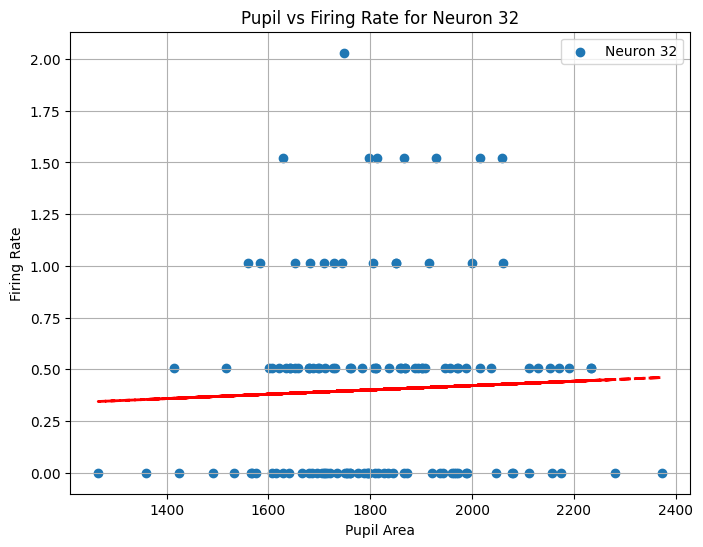

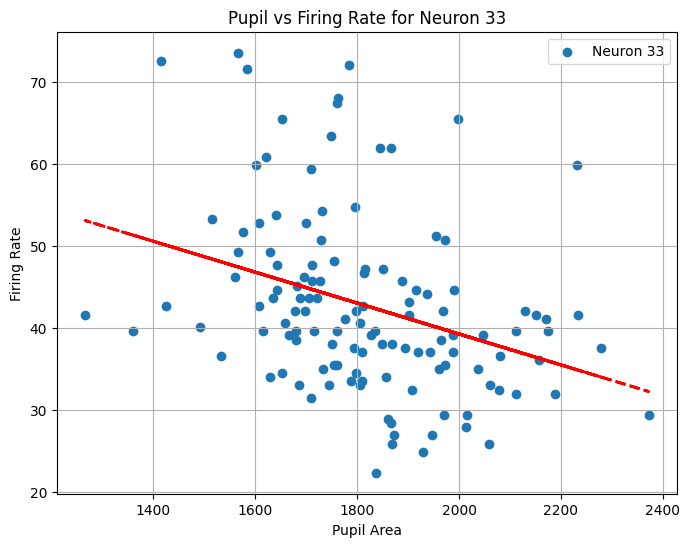

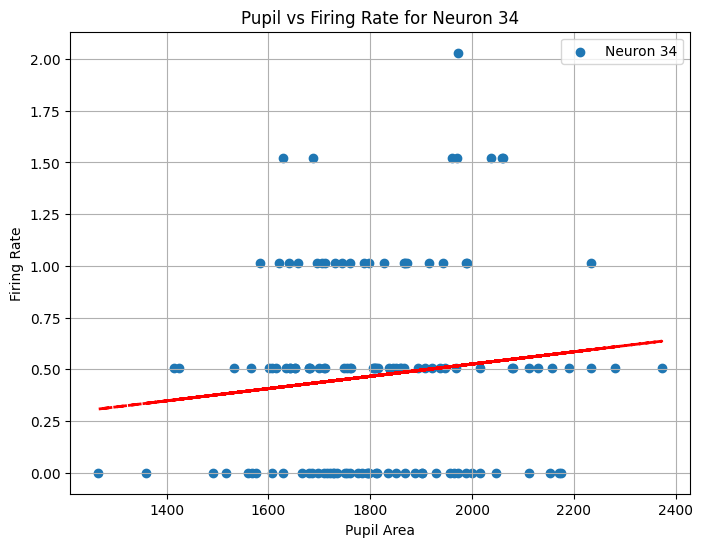

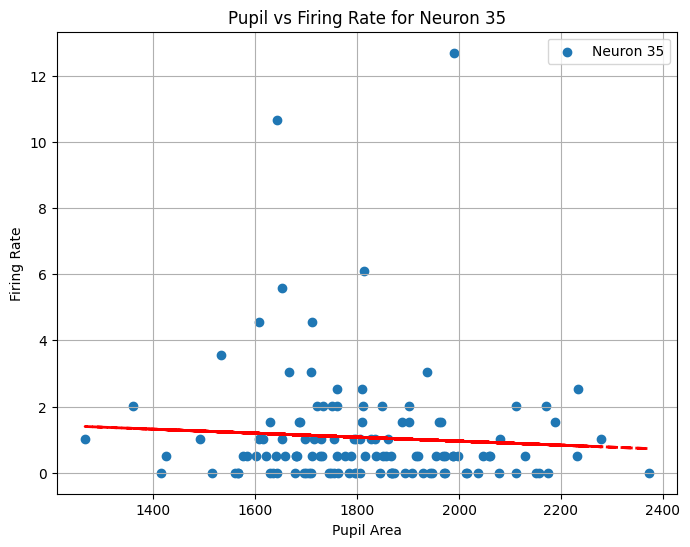

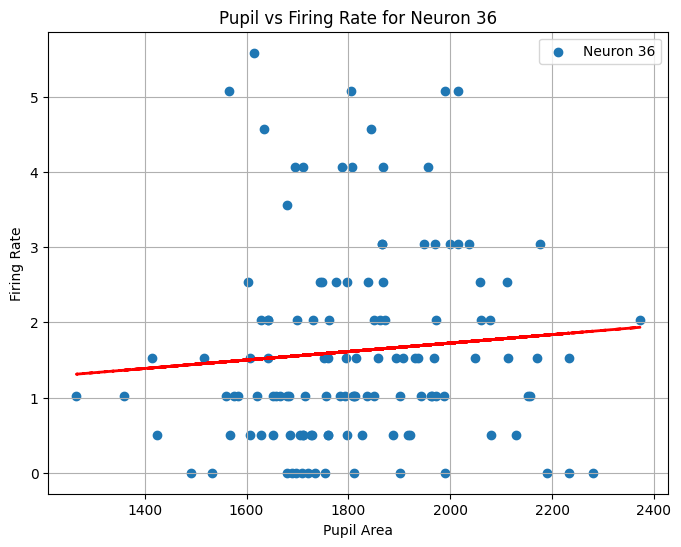

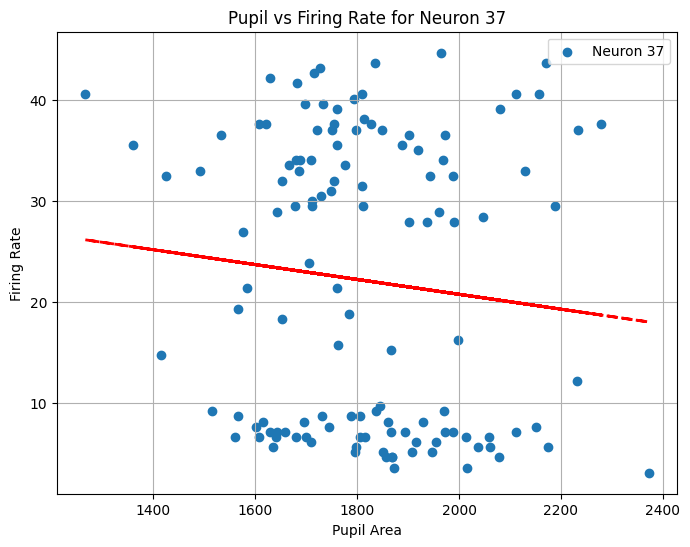

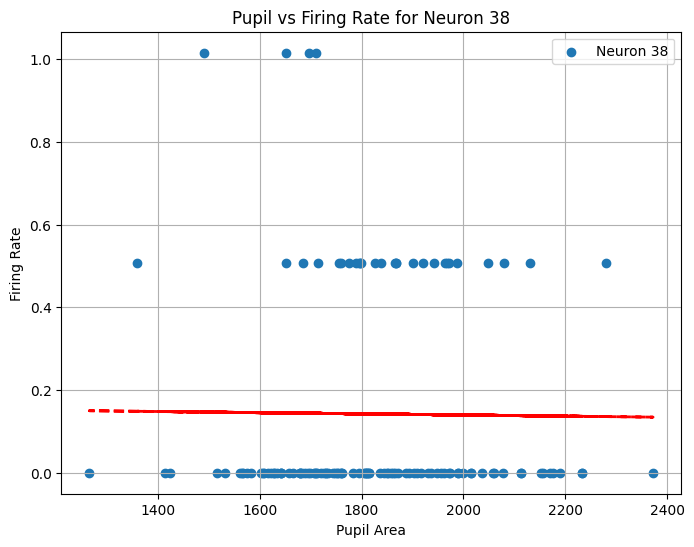

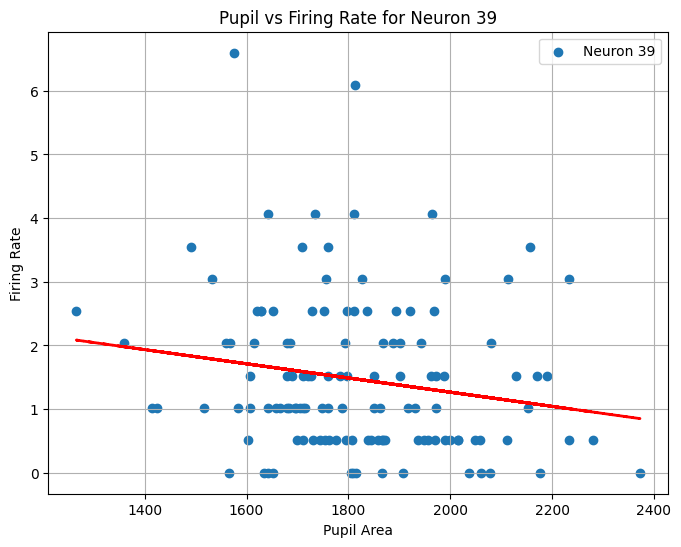

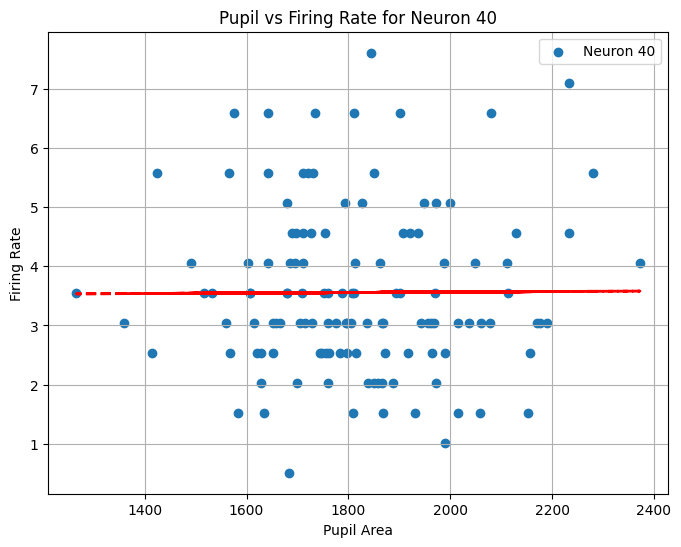

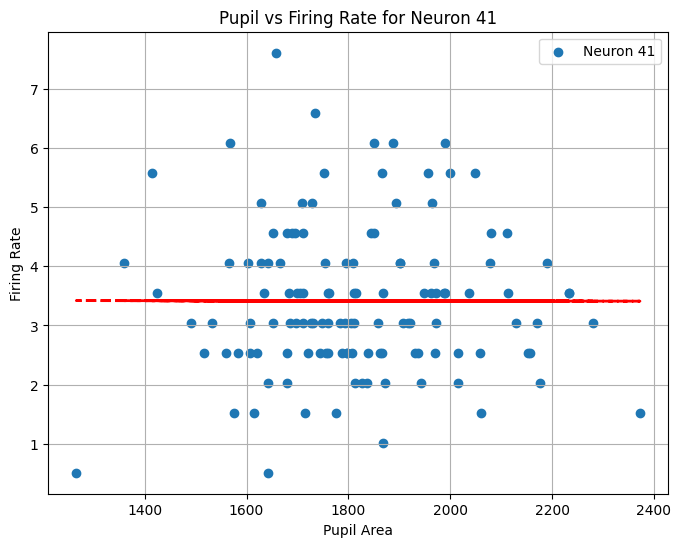

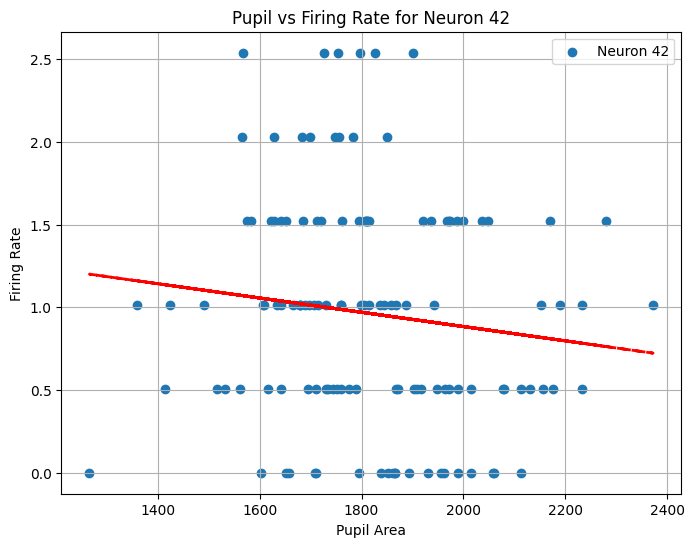

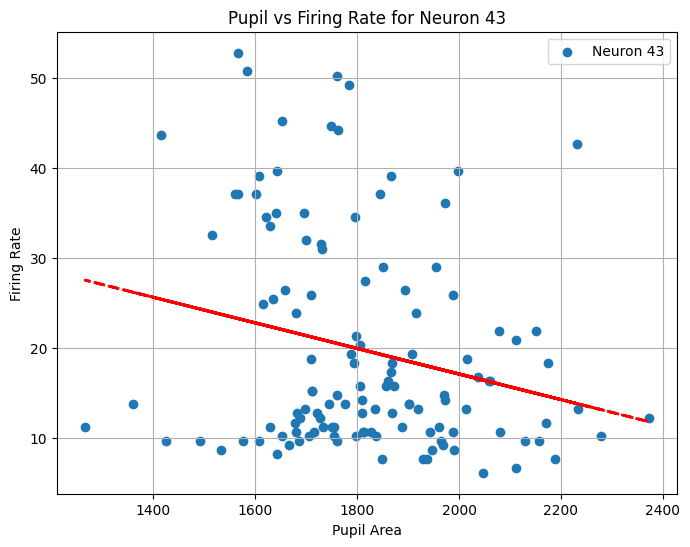

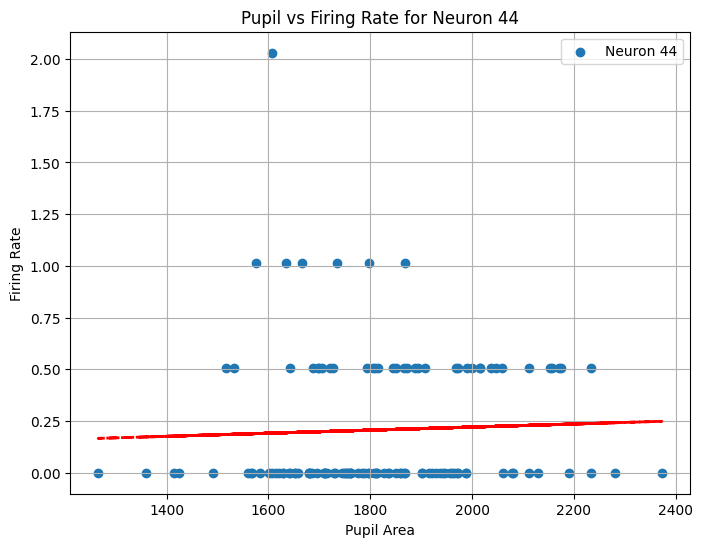

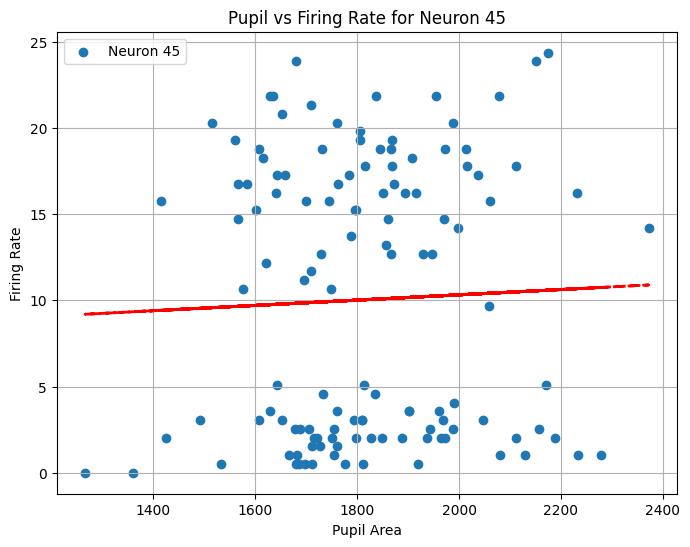

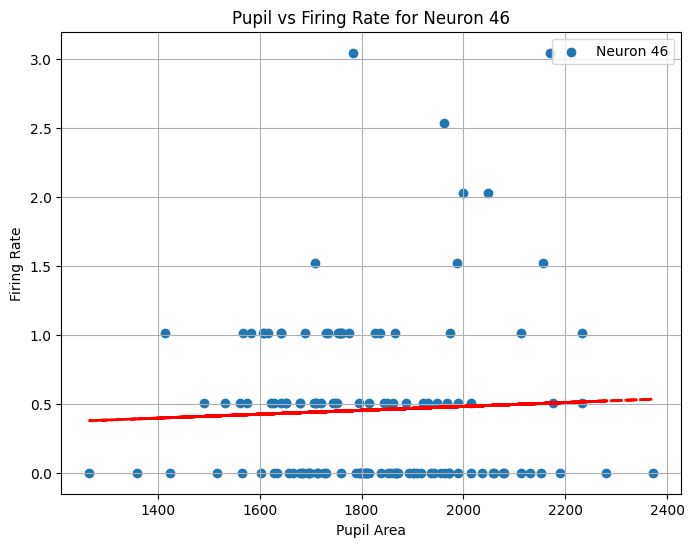

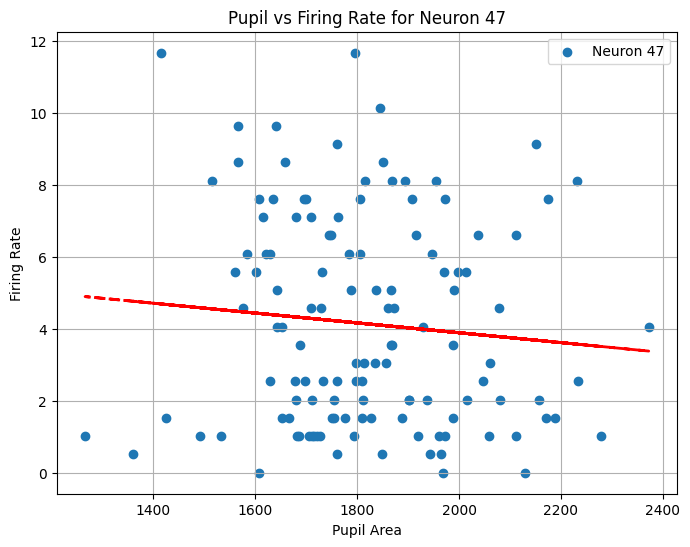

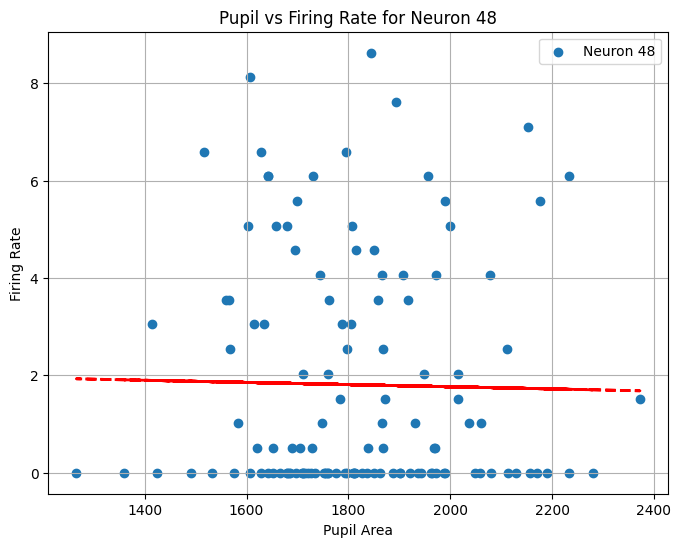

In [59]:
# Interpolate pupil area data to match the time bins of firing rate data
interp_pupil_area = interp1d(np.arange(len(all_neuron_pupil_area)), all_neuron_pupil_area)

# Plot pupil vs firing rate for each neuron
for i in range(num_neurons):
    # Create a new figure for each neuron
    plt.figure(figsize=(8, 6))
    
    # Interpolate pupil area data to match the length of firing rate data
    interp_pupil_data = interp_pupil_area(np.linspace(0, len(all_neuron_pupil_area) - 1, len(average_response[i])))
    # Fit linear regression
    slope, intercept, _, _, _ = linregress(interp_pupil_data, average_response[i])
    
    # Plot pupil vs firing rate
    plt.scatter(interp_pupil_data, average_response[i], label=f'Neuron {i+1}')
    
    # Plot the linear regression line
    plt.plot(interp_pupil_data, slope * interp_pupil_data + intercept, color='red', linewidth=2, linestyle='--')

    plt.title(f'Pupil vs Firing Rate for Neuron {i+1}')
    plt.xlabel('Pupil Area')
    plt.ylabel('Firing Rate')
    plt.legend()
    plt.grid(True)
    plt.show()

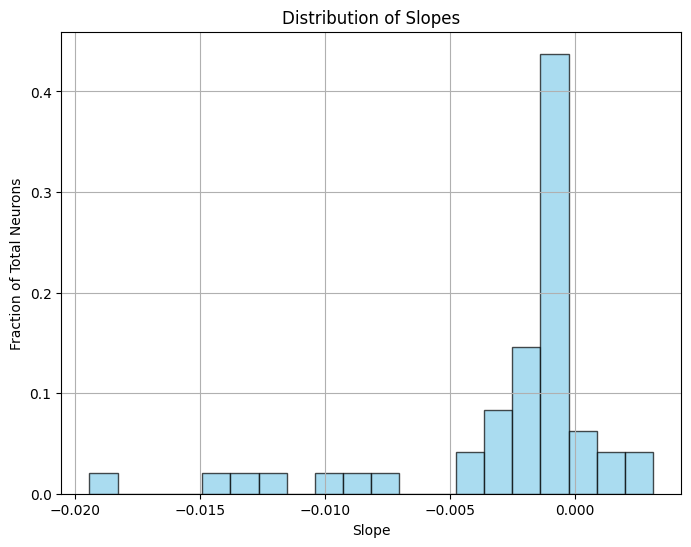

In [60]:
# Interpolate pupil area data to match the time bins of firing rate data
interp_pupil_area = interp1d(np.arange(len(all_neuron_pupil_area)), all_neuron_pupil_area)

# Fit linear regression and extract slopes for each neuron
slopes = []
for i in range(num_neurons):
    # Interpolate pupil area data to match the length of firing rate data
    interp_pupil_data = interp_pupil_area(np.linspace(0, len(all_neuron_pupil_area) - 1, len(average_response[i])))
    # Fit linear regression
    slope, _, _, _, _ = linregress(interp_pupil_data, average_response[i])
    slopes.append(slope)

# Plot histogram of slopes
plt.figure(figsize=(8, 6))
hist, bins, _ = plt.hist(slopes, bins=20, color='skyblue', edgecolor='black', alpha=0.7)

# Convert histogram counts to fraction of total neurons
total_neurons = len(slopes)
hist_fraction = hist / total_neurons

# Plot histogram with y-axis as fraction of total neurons
plt.clf()
plt.bar(bins[:-1], hist_fraction, width=np.diff(bins), color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Distribution of Slopes')
plt.xlabel('Slope')
plt.ylabel('Fraction of Total Neurons')
plt.grid(True)
plt.show()

In [29]:
# pupil aligned to changes

#define how many frames worth of data to grab
# 1s = 60 frames
# 30frames = 0.5s
pre_change_frames=30 
post_change_frames=45
total_frames=75

hit_times = hit_trials['change_time_with_display_delay']

#pre-allocate arrays to store stimulus-aligned data
hit_pupil = np.zeros((len(hit_times),total_frames))

#loop through image change times
for ii,rr in enumerate(hit_times.values):

    pupil_start_ind=np.where(eye_tracking_noblinks['timestamps']>=rr)[0][0]

    #check that we aren't trying to grab data indices that don't exist
    if ((pupil_start_ind-pre_change_frames)>=0) & ((pupil_start_ind+post_change_frames)<len(eye_tracking)):
        hit_pupil[ii,:]=eye_tracking_noblinks['pupil_area'][pupil_start_ind-pre_change_frames:
                                                                            pupil_start_ind+post_change_frames]
    else:
        hit_pupil[ii,:]=np.nan


miss_times = miss_trials['change_time_with_display_delay']
miss_pupil = np.zeros((len(miss_times),total_frames))
#loop through image change times
for ii,rr in enumerate(miss_times.values):

    pupil_start_ind=np.where(eye_tracking_noblinks['timestamps']>=rr)[0][0]

    #check that we aren't trying to grab data indices that don't exist
    if ((pupil_start_ind-pre_change_frames)>=0) & ((pupil_start_ind+post_change_frames)<len(eye_tracking)):
        miss_pupil[ii,:]=eye_tracking_noblinks['pupil_area'][pupil_start_ind-pre_change_frames:
                                                                            pupil_start_ind+post_change_frames]
    else:
        miss_pupil[ii,:]=np.nan



[-5.00000000e-01 -4.83333333e-01 -4.66666667e-01 -4.50000000e-01
 -4.33333333e-01 -4.16666667e-01 -4.00000000e-01 -3.83333333e-01
 -3.66666667e-01 -3.50000000e-01 -3.33333333e-01 -3.16666667e-01
 -3.00000000e-01 -2.83333333e-01 -2.66666667e-01 -2.50000000e-01
 -2.33333333e-01 -2.16666667e-01 -2.00000000e-01 -1.83333333e-01
 -1.66666667e-01 -1.50000000e-01 -1.33333333e-01 -1.16666667e-01
 -1.00000000e-01 -8.33333333e-02 -6.66666667e-02 -5.00000000e-02
 -3.33333333e-02 -1.66666667e-02 -1.11022302e-16  1.66666667e-02
  3.33333333e-02  5.00000000e-02  6.66666667e-02  8.33333333e-02
  1.00000000e-01  1.16666667e-01  1.33333333e-01  1.50000000e-01
  1.66666667e-01  1.83333333e-01  2.00000000e-01  2.16666667e-01
  2.33333333e-01  2.50000000e-01  2.66666667e-01  2.83333333e-01
  3.00000000e-01  3.16666667e-01  3.33333333e-01  3.50000000e-01
  3.66666667e-01  3.83333333e-01  4.00000000e-01  4.16666667e-01
  4.33333333e-01  4.50000000e-01  4.66666667e-01  4.83333333e-01
  5.00000000e-01  5.16666

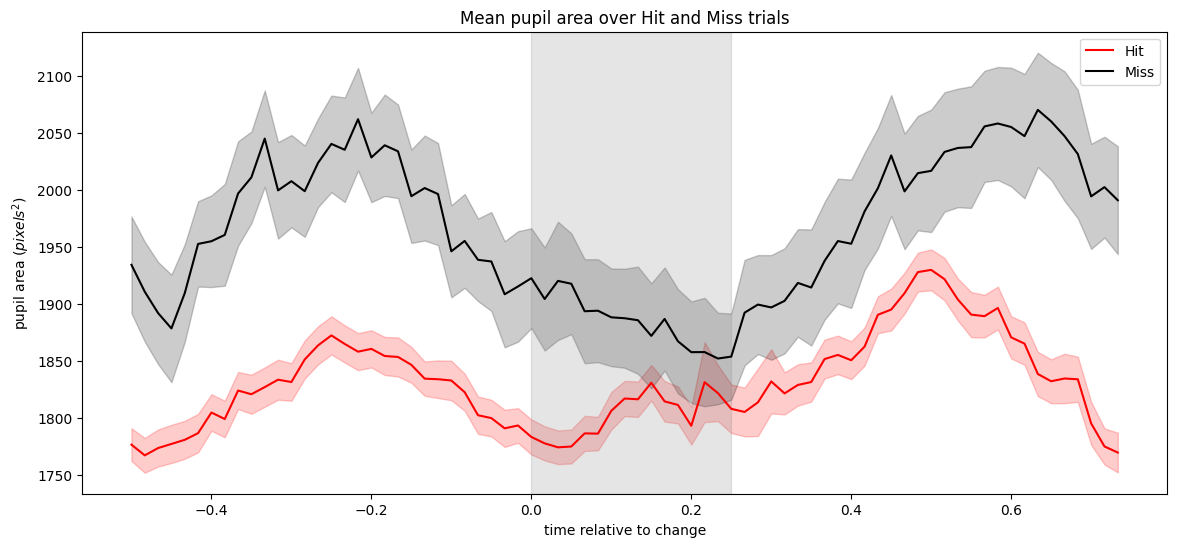

In [30]:
timevect=np.arange(-pre_change_frames/60,post_change_frames/60,1/60)
hit_trial_mean_pupil = np.nanmean(hit_pupil,0)
miss_trial_mean_pupil = np.nanmean(miss_pupil,0)

# Calculate standard error of the mean (SEM) for hit and miss trials
hit_sem = np.nanstd(hit_pupil, axis=0, ddof=1) / np.sqrt(np.sum(~np.isnan(hit_pupil), axis=0))
miss_sem = np.nanstd(miss_pupil, axis=0, ddof=1) / np.sqrt(np.sum(~np.isnan(miss_pupil), axis=0))

# Plot with error bars
fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(timevect, hit_trial_mean_pupil, 'r', label='Hit')
ax.plot(timevect, miss_trial_mean_pupil, 'k', label='Miss')

# Add error bars
ax.fill_between(timevect, hit_trial_mean_pupil - hit_sem, hit_trial_mean_pupil + hit_sem, color='red', alpha=0.2)
ax.fill_between(timevect, miss_trial_mean_pupil - miss_sem, miss_trial_mean_pupil + miss_sem, color='black', alpha=0.2)

# ax.axvline(0, color='k', linestyle='--')
# ax.axvline(0.25, color='k', linestyle='--')

ax.axvspan(0, 0.25, alpha=0.2, color='gray')

ax.set_xlabel('time relative to change')
ax.set_ylabel('pupil area $(pixels^2)$')
ax.set_title('Mean pupil area over Hit and Miss trials')
ax.legend(['Hit', 'Miss'])

plt.show()

[-5.00000000e-01 -4.83333333e-01 -4.66666667e-01 -4.50000000e-01
 -4.33333333e-01 -4.16666667e-01 -4.00000000e-01 -3.83333333e-01
 -3.66666667e-01 -3.50000000e-01 -3.33333333e-01 -3.16666667e-01
 -3.00000000e-01 -2.83333333e-01 -2.66666667e-01 -2.50000000e-01
 -2.33333333e-01 -2.16666667e-01 -2.00000000e-01 -1.83333333e-01
 -1.66666667e-01 -1.50000000e-01 -1.33333333e-01 -1.16666667e-01
 -1.00000000e-01 -8.33333333e-02 -6.66666667e-02 -5.00000000e-02
 -3.33333333e-02 -1.66666667e-02 -1.11022302e-16  1.66666667e-02
  3.33333333e-02  5.00000000e-02  6.66666667e-02  8.33333333e-02
  1.00000000e-01  1.16666667e-01  1.33333333e-01  1.50000000e-01
  1.66666667e-01  1.83333333e-01  2.00000000e-01  2.16666667e-01
  2.33333333e-01  2.50000000e-01  2.66666667e-01  2.83333333e-01
  3.00000000e-01  3.16666667e-01  3.33333333e-01  3.50000000e-01
  3.66666667e-01  3.83333333e-01  4.00000000e-01  4.16666667e-01
  4.33333333e-01  4.50000000e-01  4.66666667e-01  4.83333333e-01
  5.00000000e-01  5.16666

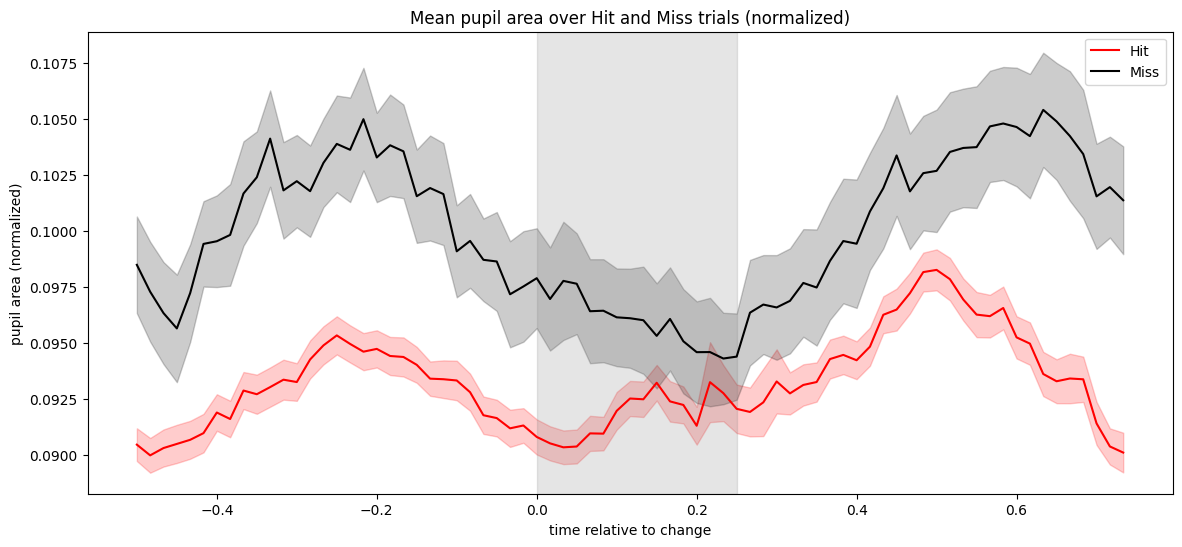

In [39]:
import numpy as np
import matplotlib.pyplot as plt


# Define how many frames worth of data to grab
pre_change_frames = 30
post_change_frames = 45
total_frames = 75

hit_times = hit_trials['change_time_with_display_delay']

# Pre-allocate arrays to store stimulus-aligned data
hit_pupil = np.zeros((len(hit_times), total_frames))

# Find the maximum pupil area value across the entire session
max_pupil_value = np.max(eye_tracking_noblinks['pupil_area'])

# Loop through image change times for hit trials
for ii, rr in enumerate(hit_times.values):
    pupil_start_ind = np.where(eye_tracking_noblinks['timestamps'] >= rr)[0][0]

    # Check that we aren't trying to grab data indices that don't exist
    if ((pupil_start_ind - pre_change_frames) >= 0) & ((pupil_start_ind + post_change_frames) < len(eye_tracking)):
        trial_data = eye_tracking_noblinks['pupil_area'][pupil_start_ind - pre_change_frames:
                                                         pupil_start_ind + post_change_frames]
        hit_pupil[ii, :] = trial_data / max_pupil_value
    else:
        hit_pupil[ii, :] = np.nan

miss_times = miss_trials['change_time_with_display_delay']
miss_pupil = np.zeros((len(miss_times), total_frames))

# Loop through image change times for miss trials
for ii, rr in enumerate(miss_times.values):
    pupil_start_ind = np.where(eye_tracking_noblinks['timestamps'] >= rr)[0][0]

    # Check that we aren't trying to grab data indices that don't exist
    if ((pupil_start_ind - pre_change_frames) >= 0) & ((pupil_start_ind + post_change_frames) < len(eye_tracking)):
        trial_data = eye_tracking_noblinks['pupil_area'][pupil_start_ind - pre_change_frames:
                                                         pupil_start_ind + post_change_frames]
        miss_pupil[ii, :] = trial_data / max_pupil_value
    else:
        miss_pupil[ii, :] = np.nan

timevect = np.arange(-pre_change_frames / 60, post_change_frames / 60, 1 / 60)
hit_trial_mean_pupil = np.nanmean(hit_pupil, 0)
miss_trial_mean_pupil = np.nanmean(miss_pupil, 0)

# Calculate standard error of the mean (SEM) for hit and miss trials
hit_sem = np.nanstd(hit_pupil, axis=0, ddof=1) / np.sqrt(np.sum(~np.isnan(hit_pupil), axis=0))
miss_sem = np.nanstd(miss_pupil, axis=0, ddof=1) / np.sqrt(np.sum(~np.isnan(miss_pupil), axis=0))

# Plot with error bars
fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(timevect, hit_trial_mean_pupil, 'r', label='Hit')
ax.plot(timevect, miss_trial_mean_pupil, 'k', label='Miss')

# Add error bars
ax.fill_between(timevect, hit_trial_mean_pupil - hit_sem, hit_trial_mean_pupil + hit_sem, color='red', alpha=0.2)
ax.fill_between(timevect, miss_trial_mean_pupil - miss_sem, miss_trial_mean_pupil + miss_sem, color='black', alpha=0.2)

ax.axvspan(0, 0.25, alpha=0.2, color='gray')

ax.set_xlabel('time relative to change')
ax.set_ylabel('pupil area (normalized)')
ax.set_title('Mean pupil area over Hit and Miss trials (normalized)')
ax.legend(['Hit', 'Miss'])

print(timevect)


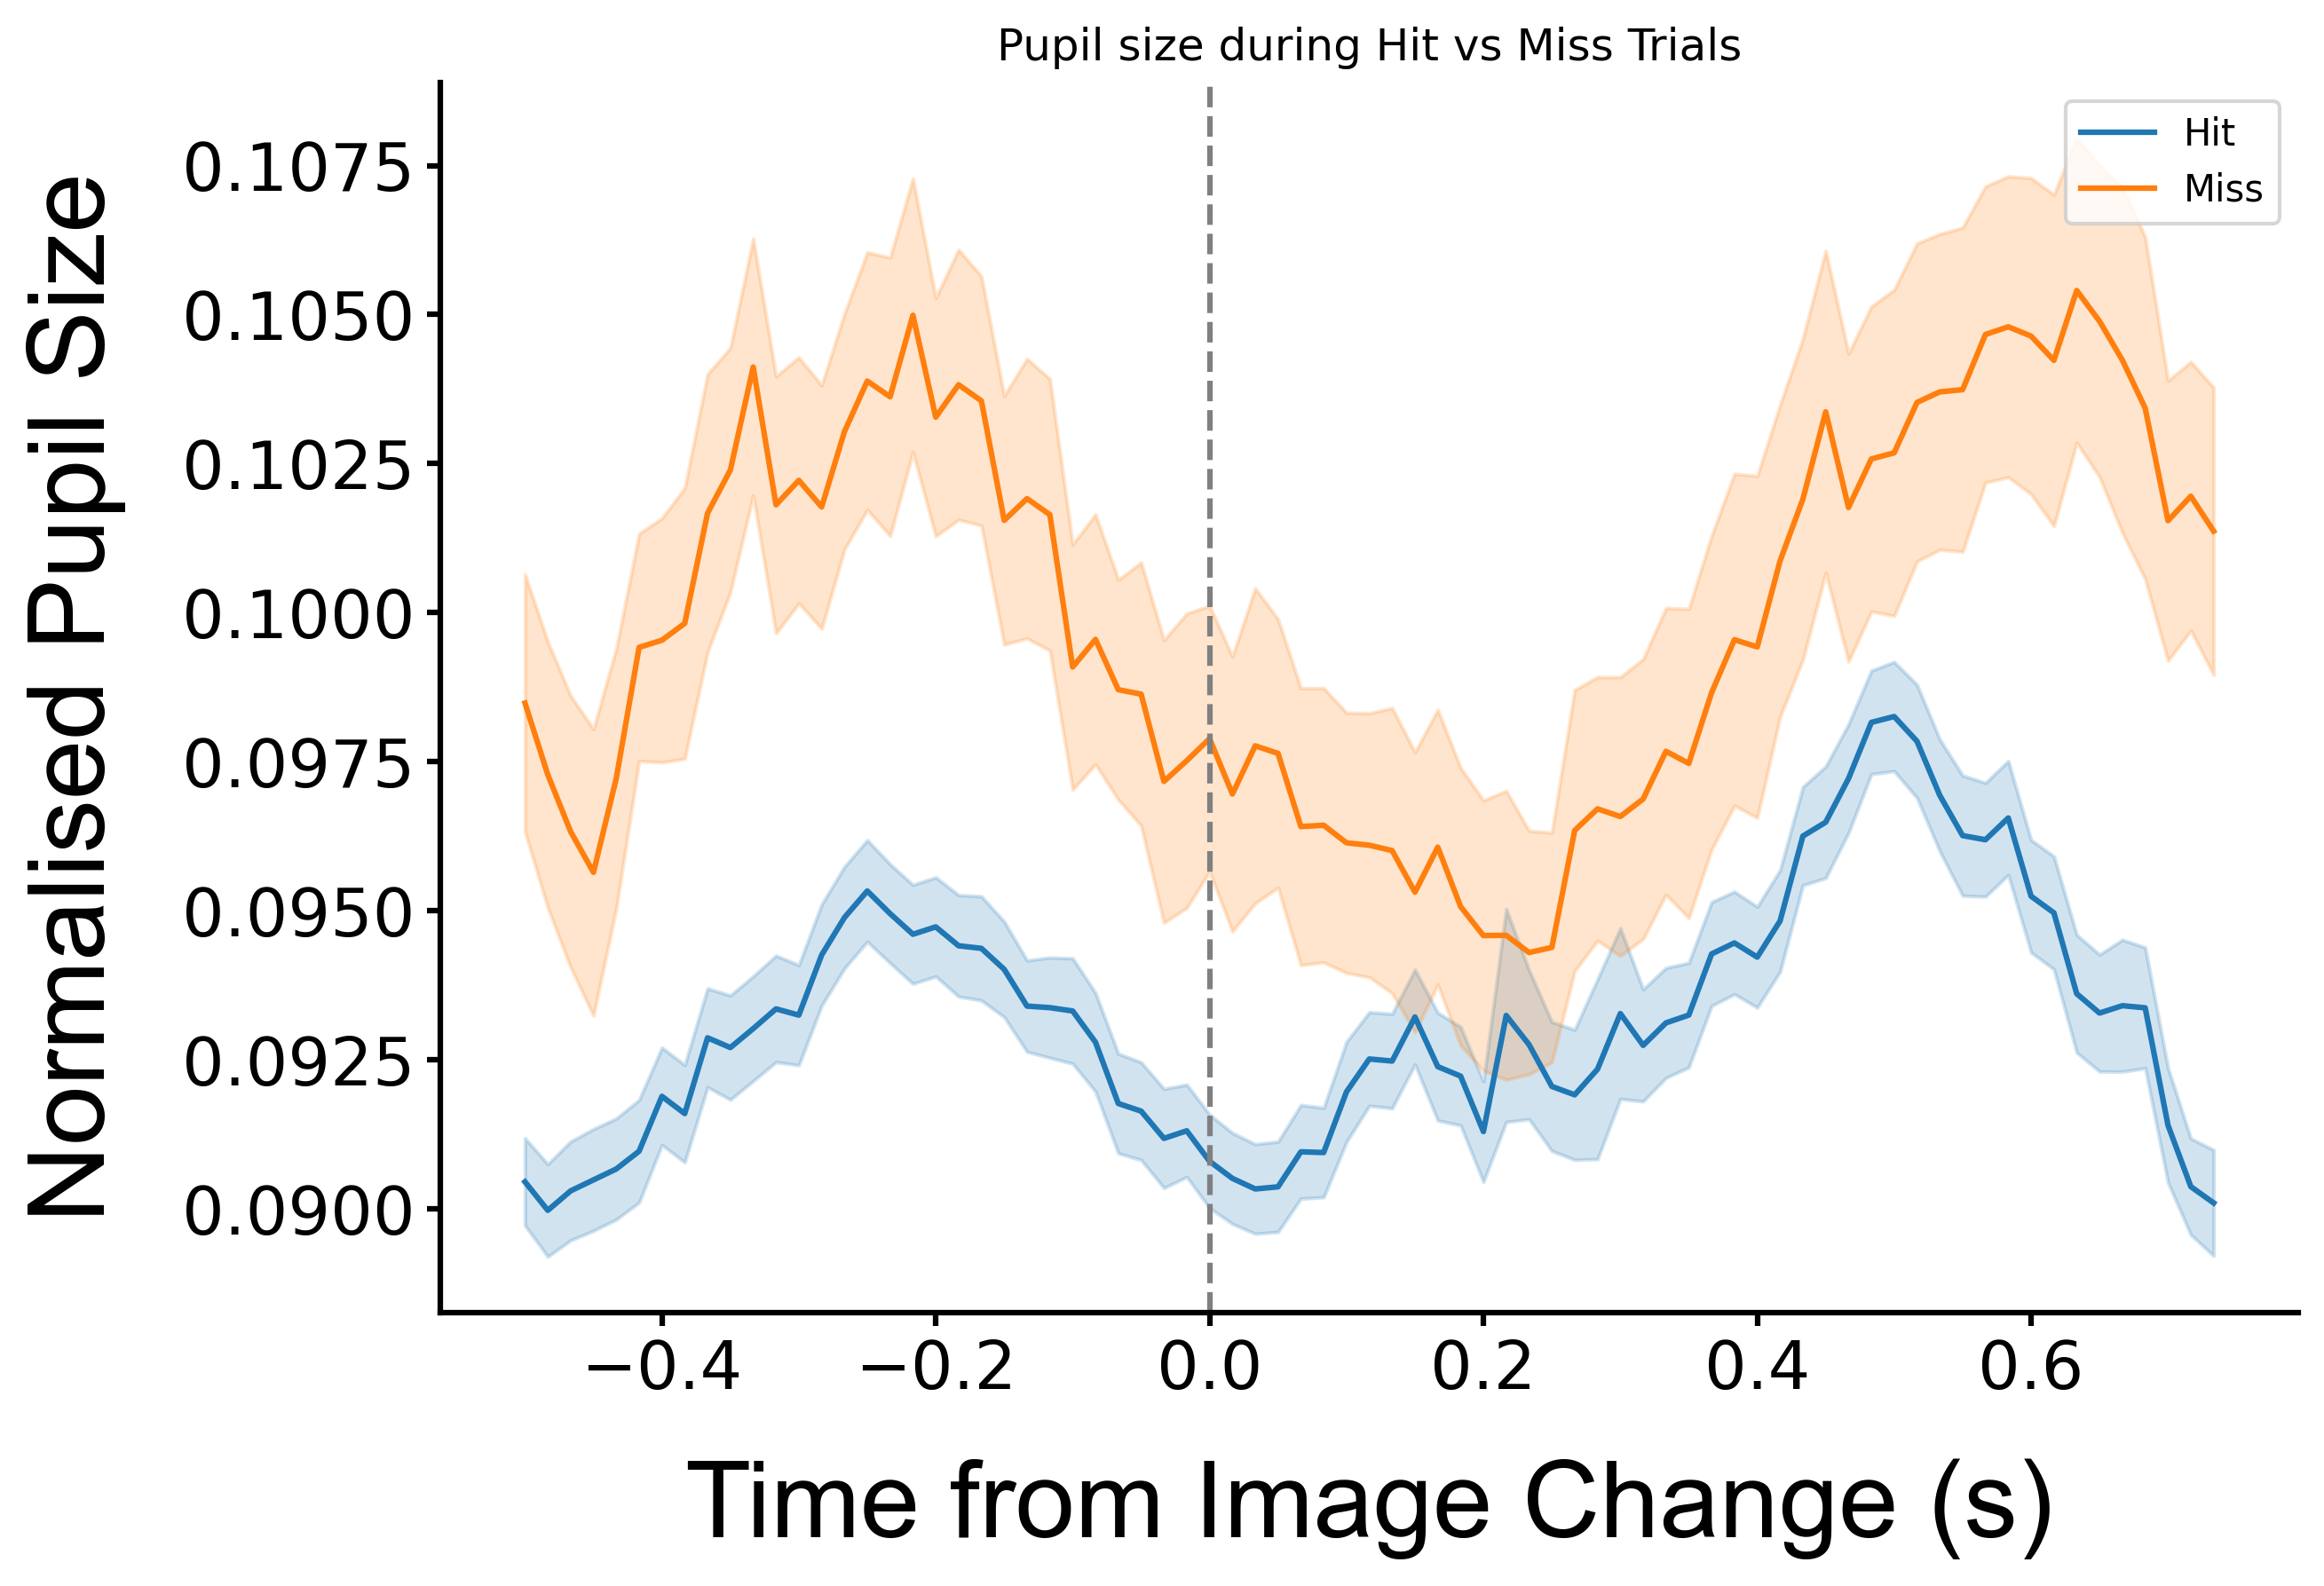

In [40]:
# plot mean
fig, ax = plt.subplots(dpi=300)
fig.set_size_inches(9,6)

# ax.plot(timevect, hit_trial_mean_pupil, 'r', label='Hit')
# ax.plot(timevect, miss_trial_mean_pupil, 'k', label='Miss')

# Plot the mean of interpolated_data over time bins
ax.plot(timevect, hit_trial_mean_pupil, color='#1f77b4', label='Hit') #blue Hit
ax.plot(timevect, miss_trial_mean_pupil, color='#ff7f0e', label='Miss') # Orange miss

ax.fill_between(timevect, hit_trial_mean_pupil - hit_sem, hit_trial_mean_pupil + hit_sem, color='#1f77b4', alpha=0.2)
ax.fill_between(timevect, miss_trial_mean_pupil - miss_sem, miss_trial_mean_pupil + miss_sem, color='#ff7f0e', alpha=0.2)

# Calculate standard deviation of interpolated_data over time bins
# std_hit  = np.std(hit_trial_mean_pupil, axis=0)

# Shade between the error bars
# ax.fill_between(time_bins, mean_interpolated_data_hit - std_interpolated_data_hit, mean_interpolated_data_hit + std_interpolated_data_hit, color='#1f77b4', alpha=0.2) # Blue hit
# ax.fill_between(time_bins, mean_interpolated_data_miss - std_interpolated_data_miss, mean_interpolated_data_miss + std_interpolated_data_miss, color='#ff7f0e', alpha=0.2) # Orange miss

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_linewidth(1.5)  # Adjust the width as needed
ax.spines['left'].set_linewidth(1.5)

# ax.set_ylim(2,2.6)
# ax.set_ylim(1,1.6)

ax.axvline(x=0, color='grey', linestyle='--') # Vstim onset with delay
ax.set_title(f'Pupil size during Hit vs Miss Trials')
ax.set_ylabel('Normalised Pupil Size', labelpad=15, size=29, fontweight=1.5, family='Arial')
ax.set_xlabel('Time from Image Change (s)', labelpad=15, size=29, fontweight=1.5, family='Arial')
ax.tick_params(axis='x', labelsize=18, width=1.5)
ax.tick_params(axis='y', labelsize=18, width=1.5)
ax.legend()

In [38]:
from scipy.stats import ttest_ind

# Perform independent samples t-test
t_stat, p_value = ttest_ind(hit_trial_mean_pupil, miss_trial_mean_pupil)

# Display the results
print(f'T-statistic: {t_stat}')
print(f'P-value: {p_value}')

# Check for statistical significance
alpha = 0.05
if p_value < alpha:
    print('The difference between hit and miss mean pupil sizes is statistically significant.')
else:
    print('There is no significant difference between hit and miss mean pupil sizes.')

T-statistic: -15.110800873692968
P-value: 8.500678221791125e-32
The difference between hit and miss mean pupil sizes is statistically significant.


# Correlation pupil size and firing rate during Hit/Miss

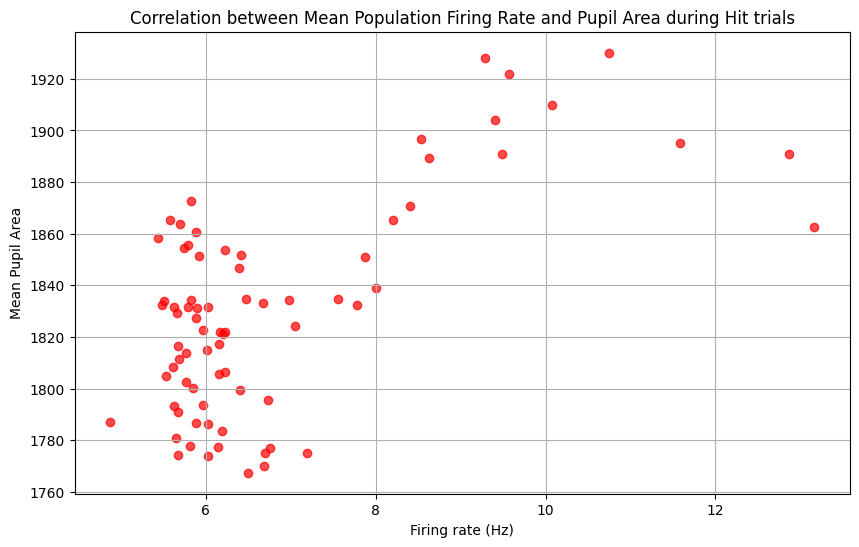

In [39]:
# Downsample the mean_hit_firing_rate or mean_miss_firing_rate to the same size of hit_trial_mean_pupil
# Calculate the downsampling factor
downsample_factor_hit = len(mean_hit_firing_rate) // len(hit_trial_mean_pupil)

# Reshape the firing rate array to match the length of the pupil size array
resized_firing_rate_hit = mean_hit_firing_rate[:len(hit_trial_mean_pupil) * downsample_factor_hit]

# Reshape and take the mean within each bin
downsampled_mean_firing_rate_hit = resized_firing_rate_hit.reshape(len(hit_trial_mean_pupil), downsample_factor_hit).mean(axis=1)

# Create and plot the correlation
plt.figure(figsize=(10, 6))
plt.scatter(downsampled_mean_firing_rate_hit, hit_trial_mean_pupil, marker='o', color='red', alpha=0.7)
plt.title(f'Correlation between Mean Population Firing Rate and Pupil Area during Hit trials')
plt.xlabel('Firing rate (Hz)')
plt.ylabel('Mean Pupil Area')
plt.grid(True)

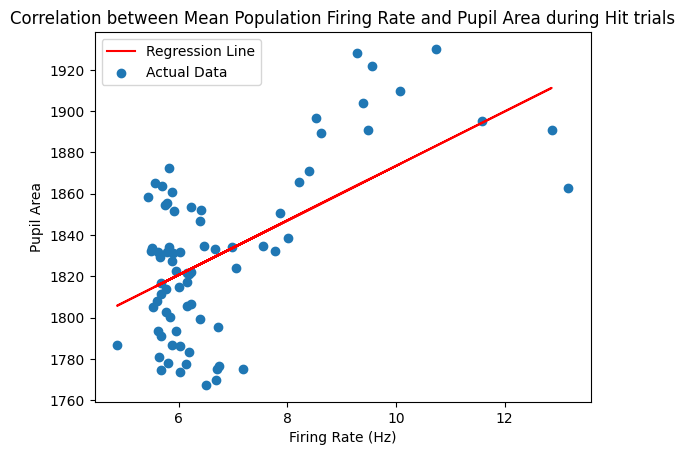

Coefficients: [13.19519532]
Mean Squared Error: 932.9020257685952
R-squared: 0.4519095720528976


In [40]:
# linear regression

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

rand_seed = 42
np.random.seed(rand_seed)

X = np.array(downsampled_mean_firing_rate_hit).reshape(-1, 1)
Y = np.array(hit_trial_mean_pupil)

# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.5, random_state=42)

# Create a linear regression model
model = LinearRegression()

# Train the model
model.fit(X_train, Y_train)

# Make predictions on the testing set
Y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(Y_test, Y_pred)
r_squared = model.score(X_test, Y_test)

# Plot the data and the regression line
plt.scatter(X, Y, label='Actual Data')
plt.plot(X_test, Y_pred, color='red', label='Regression Line')
plt.title(f'Correlation between Mean Population Firing Rate and Pupil Area during Hit trials')
plt.xlabel('Firing Rate (Hz)')
plt.ylabel('Pupil Area')
plt.legend()
plt.show()

print(f'Coefficients: {model.coef_}')
print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r_squared}')

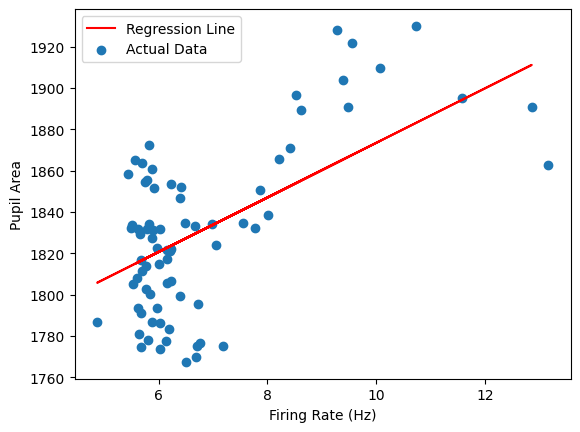

Ridge Coefficients: [13.0333329]
Mean Squared Error (Ridge): 936.72945228782
R-squared (Ridge): 0.4496609159444175


In [41]:
# Create a Ridge regression model

from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV, train_test_split

# Grid research to find the best alphas
# # Define a range of alpha values to search over
# alphas = [1.417, 1.418, 1.4185]

# # Create a Ridge regression model
# ridge_model = Ridge()

# # Perform a grid search over alpha values
# param_grid = {'alpha': alphas}
# grid_search = GridSearchCV(estimator=ridge_model, param_grid=param_grid, cv=5)
# grid_search.fit(X_train, Y_train)

# # Print the best alpha value and corresponding performance
# best_alpha = grid_search.best_params_['alpha']
# print(f'Best Alpha: {best_alpha}')

# # Train the Ridge model with the best alpha
# best_ridge_model = Ridge(alpha=best_alpha)
# best_ridge_model.fit(X_train, Y_train)

# # Make predictions on the testing set
# Y_pred_best_ridge = best_ridge_model.predict(X_test)

alpha = 1.418  # Regularization strength, adjust as needed
ridge_model = Ridge(alpha=alpha)

# Train the Ridge model
ridge_model.fit(X_train, Y_train)

# Make predictions on the testing set
Y_pred_ridge = ridge_model.predict(X_test)

# Evaluate the Ridge model
mse_ridge = mean_squared_error(Y_test, Y_pred_ridge)
r_squared_ridge = ridge_model.score(X_test, Y_test)

# Plot the data and the Ridge regression line
plt.scatter(X, Y, label='Actual Data')
plt.plot(X_test, Y_pred, color='red', label='Regression Line')
plt.xlabel('Firing Rate (Hz)')
plt.ylabel('Pupil Area')
plt.legend()
plt.show()

# Display the coefficients and evaluation metrics for Ridge regression
print(f'Ridge Coefficients: {ridge_model.coef_}')
print(f'Mean Squared Error (Ridge): {mse_ridge}')
print(f'R-squared (Ridge): {r_squared_ridge}')

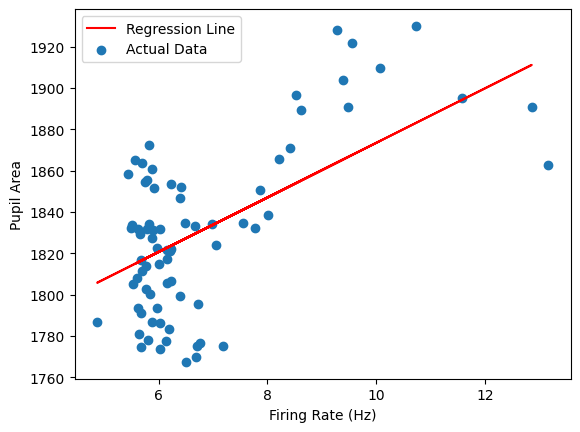

Coefficients: [13.19519532]
Mean Squared Error: 932.9020257685952
R-squared: 0.4519095720528976


In [42]:
# Lasso regression
from sklearn.linear_model import Lasso

# Create a Lasso regression model
alpha = 1.0  # Regularization strength, adjust as needed
lasso_model = Lasso(alpha=alpha)

# Train the Lasso model
lasso_model.fit(X_train, Y_train)

# Make predictions on the testing set
Y_pred_lasso = lasso_model.predict(X_test)

# Evaluate the Lasso model
mse_lasso = mean_squared_error(Y_test, Y_pred_lasso)
r_squared_lasso = lasso_model.score(X_test, Y_test)

# Plot the data and the regression line
plt.scatter(X, Y, label='Actual Data')
plt.plot(X_test, Y_pred, color='red', label='Regression Line')
plt.xlabel('Firing Rate (Hz)')
plt.ylabel('Pupil Area')
plt.legend()
plt.show()

print(f'Coefficients: {model.coef_}')
print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r_squared}')

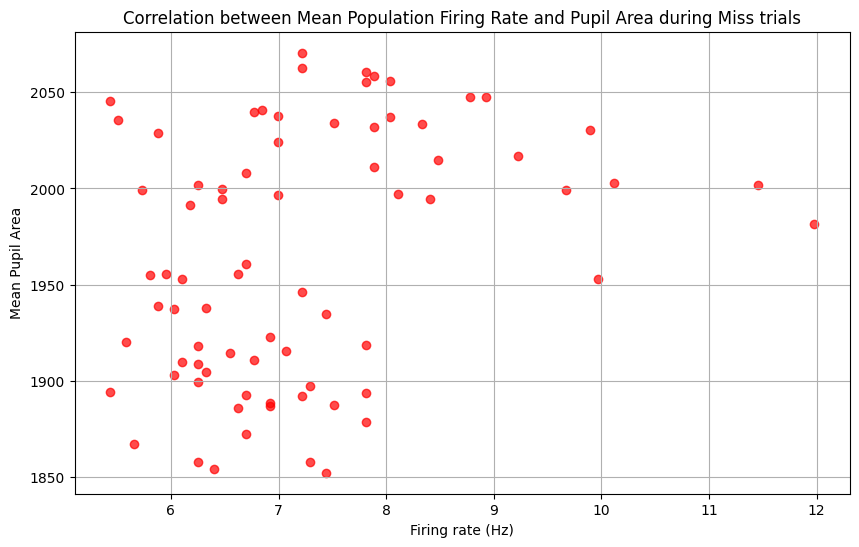

In [43]:
# Downsample the mean_miss_firing_rate to the same size of miss_trial_mean_pupil
# Calculate the downsampling factor
downsample_factor_miss = len(mean_miss_firing_rate) // len(miss_trial_mean_pupil)

# Reshape the firing rate array to match the length of the pupil size array
resized_firing_rate_miss = mean_miss_firing_rate[:len(miss_trial_mean_pupil) * downsample_factor_miss]

# Reshape and take the mean within each bin
downsampled_mean_firing_rate_miss = resized_firing_rate_miss.reshape(len(miss_trial_mean_pupil), downsample_factor_miss).mean(axis=1)

# Create and plot the correlation
plt.figure(figsize=(10, 6))
plt.scatter(downsampled_mean_firing_rate_miss, miss_trial_mean_pupil, marker='o', color='red', alpha=0.7)
plt.title(f'Correlation between Mean Population Firing Rate and Pupil Area during Miss trials')
plt.xlabel('Firing rate (Hz)')
plt.ylabel('Mean Pupil Area')
plt.grid(True)

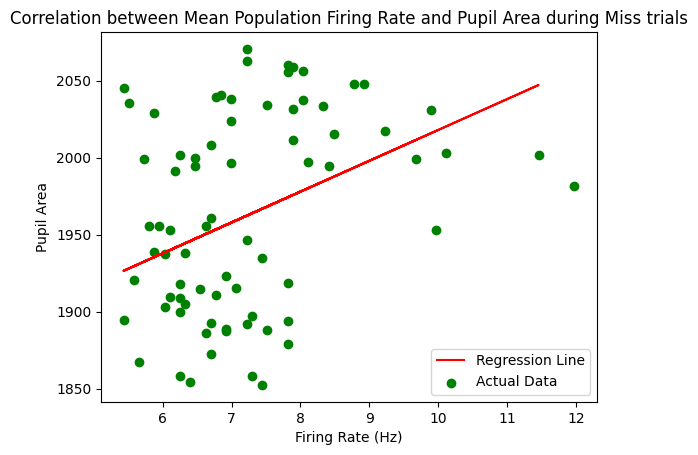

Coefficients: [20.01917766]
Mean Squared Error: 4101.927005762208
R-squared: 0.012749117855018643


In [44]:
# linear regression fit miss FR vs pupil size

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

rand_seed = 42
np.random.seed(rand_seed)

X = np.array(downsampled_mean_firing_rate_miss).reshape(-1, 1)
Y = np.array(miss_trial_mean_pupil)

# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.5, random_state=42)

# Create a linear regression model
model = LinearRegression()

# Train the model
model.fit(X_train, Y_train)

# Make predictions on the testing set
Y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(Y_test, Y_pred)
r_squared = model.score(X_test, Y_test)

# Plot the data and the regression line
plt.scatter(X, Y, label='Actual Data', color='green')
plt.plot(X_test, Y_pred, color='red', label='Regression Line')
plt.title(f'Correlation between Mean Population Firing Rate and Pupil Area during Miss trials')
plt.xlabel('Firing Rate (Hz)')
plt.ylabel('Pupil Area')
plt.legend()
plt.show()

print(f'Coefficients: {model.coef_}')
print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r_squared}')

In [45]:
df_fr_pupil_group = pd.DataFrame()

df_fr_pupil_group['downsampled_mean_firing_rate_hit']= downsampled_mean_firing_rate_hit
df_fr_pupil_group['hit_trial_mean_pupil'] = hit_trial_mean_pupil
df_fr_pupil_group['downsampled_mean_firing_rate_miss']= downsampled_mean_firing_rate_miss
df_fr_pupil_group['miss_trial_mean_pupil'] = miss_trial_mean_pupil

# Save df to csv
csv_file_name = f'FiringRate_Pupil_{ecephys_id}.csv'

df_fr_pupil_group.to_csv(csv_file_name, index=False)

# Behaviour plot

In [46]:
session.get_performance_metrics()

{'trial_count': 715,
 'go_trial_count': 194,
 'catch_trial_count': 31,
 'hit_trial_count': 166,
 'miss_trial_count': 28,
 'false_alarm_trial_count': 7,
 'correct_reject_trial_count': 24,
 'auto_reward_count': 3,
 'earned_reward_count': 166,
 'total_reward_count': 169,
 'total_reward_volume': 0.5129999999999999,
 'maximum_reward_rate': 4.761503651109667,
 'engaged_trial_count': 637,
 'mean_hit_rate': 0.928479767529586,
 'mean_hit_rate_uncorrected': 0.9381655769585986,
 'mean_hit_rate_engaged': 0.9317523140858425,
 'mean_false_alarm_rate': 0.34170336123824496,
 'mean_false_alarm_rate_uncorrected': 0.3254242914708031,
 'mean_false_alarm_rate_engaged': 0.34096365731879746,
 'mean_dprime': 2.049551959018238,
 'mean_dprime_engaged': 2.050863767057955,
 'max_dprime': 2.838721825636262,
 'max_dprime_engaged': 2.838721825636262}

In [47]:
# get the licks table
licks = session.licks

# Calculating response latency

Text(0, 0.5, 'Trial count')

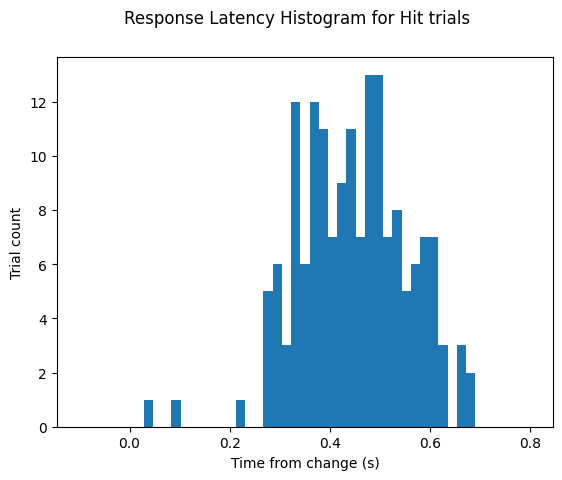

In [48]:

# find the time of the first lick after each change
lick_indices = np.searchsorted(licks.timestamps, hit_trials['change_time_with_display_delay'])
first_lick_times = licks.timestamps.values[lick_indices]
response_latencies = first_lick_times - hit_trials['change_time_with_display_delay']

# plot the latencies
fig, ax = plt.subplots()
fig.suptitle('Response Latency Histogram for Hit trials')
ax.hist(response_latencies, bins=np.linspace(-0.1, 0.8, 50))
ax.set_xlabel('Time from change (s)')
ax.set_ylabel('Trial count')